#**Trabajo Integrador**

#Entrega Final

Profesor:
- OSIMANI, Cesar Alejandro.

Alumnos:
- ARNDT HAASE, Eric Julian
- BLANCO, Leandro
- DE ELEJALDE, Asdrubal Gonzalo
- FIGUEROA, Candela Belén

📡 Sistema PAM4 — Transmisión, Canal, Recepción y Monitor
Este proyecto implementa un flujo completo para transmisión de datos codificados en PAM4, envío por TCP/IP, y visualización en tiempo real.

Incluye:

- Transmisor (MikroC, Python)
- Canal (TCP con posibilidad de ruido)
- Receptor (decodificación PAM4)
- Monitor (GUI PyQt6 para análisis y comparación)

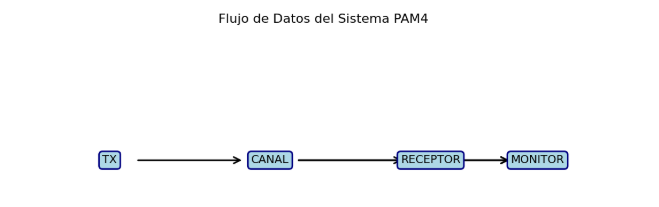

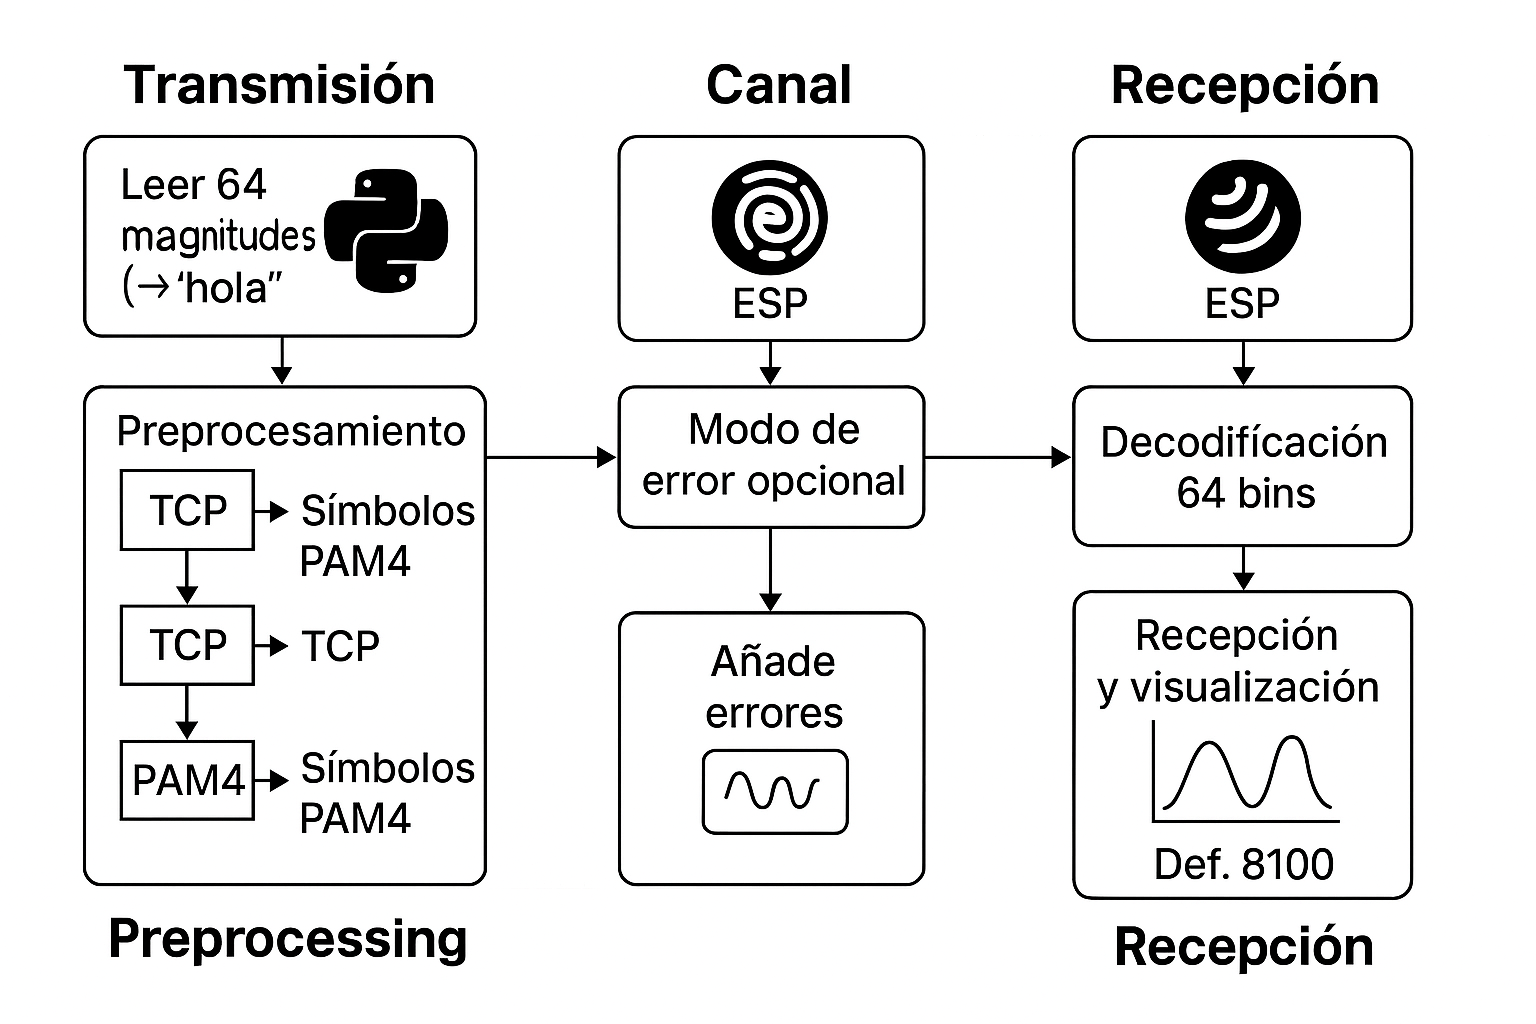

#***Transmisor***

Utiliza la placa Easy dsPIC v7 con un dsPIC30F4013.
Muestrea una señal analógica por la entrada AN2, con frecuencia aproximada de 1 Hz.

Los datos digitalizados se envían por UART hacia una PC transmisora.
Un programa en Python toma los símbolos, realiza la modulación PAM4 y transmite por WiFi (TCP) hacia:

El ESP32 canal, que simula el medio de transmisión.
Una laptop de monitoreo, encargada de visualizar las señales.

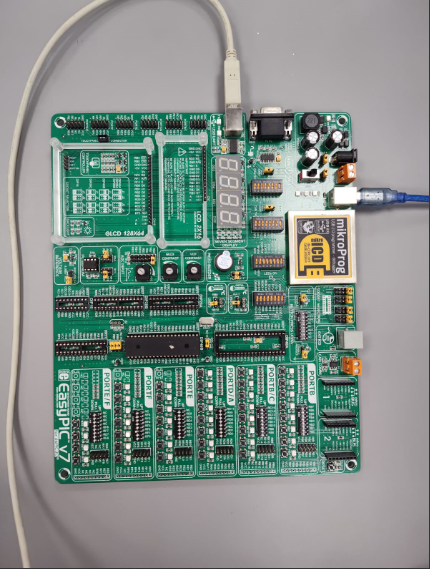

##Codigo del DSPIC


In [ ]:
// dsPIC30F4013
// Placa Easy dsPIC
// Entrada analogica AN8 - VRef es AVdd y AVss -
// Detecta las frecuencias 100 Hz, 200 Hz, 300 Hz, ..., 6300 Hz
// Publica el resultado en binario en los puertos RB0-RB5 (valores desde 1 al 63)

const unsigned long CANT_MUESTRAS = 128;  // 128 pares de valores [Re, Im]
const unsigned long FREC_MUESTREO  = 12800;  // Frecuencia de muestreo.

unsigned Samples[ CANT_MUESTRAS * 2 ];  // Capacidad para 256. Porque son 128 pares

// La funcion FFT requiere que las muestras se almacenen en el bloque de datos Y.
// Este bloque de memoria es una caracteristica de los dsPIC que permite realizar
// operaciones en una sola instruccion, lo que aumenta la velocidad de calculo.
ydata unsigned InputSamples[ CANT_MUESTRAS * 2 ];

// Almacena la frecuencia con mayor potencia en la senal de entrada
unsigned freq = 0;
unsigned freq_old = 0;  // Para almacenar la frecuencia detectada anteriormente. Para ver si se detecto una nueva o no.

// Es un indice para llevar la cuenta de cuantas muestras vamos guardando en Samples.
unsigned globali = 0;

// Bandera para saber si ya se encuentra listo el procesamiento FFT para mostrar el resultado.
char listo = 0;

// Para almacenar lo que se lee por el UART
char uart_rd;
// Para almacenar lo que se escribe a la UART
char uart_wr[ 7 ];


// Para almacenar los valores de cada una de las frecuencias
char magnitudFrecuencias[ CANT_MUESTRAS / 2 ];


void configuracionADC()  {
    ADPCFG = 0b01111111;  // elegimos AN7 como entrada para muestras
    ADCHS = 0b0111; // usamos AN7 para recibir las muestras en el ADC
    ADCON1bits.SSRC = 0b111; //  Internal counter ends sampling and starts conversion (auto convert)
    ADCON1bits.FORM = 0b11;  // Signed Fractional (DOUT = sddd dddd dd00 0000)
    ADCON2bits.VCFG = 0b000;  // tension de referencia Avdd y Avss
}

// Auxiliary function for converting 1.15 radix point to IEEE floating point variable (needed for sqrt).
float Fract2Float( int input )  {
    if ( input < 0 )
        input = - input;
    return ( input / 32768. );
}

// Analiza los componentes de la FFT para luego publicar el resultado en los puertos RB0-RB5
// Las muestras "Samples" contiene la secuencia Re, Im, Re, Im...
void obtenerResultado() {
    unsigned Re, Im, k, max;
    unsigned i = 0;  // Solo como indice para ir avanzando sobre InputSamples
    float    ReFloat, ImFloat, amplitud;

    // La k corresponde al componente, k=0 para la continua, k=1 para 100 Hz,
    // k=2 para 200 Hz, etc. hasta k=63 para 6300 Hz
    k = 0;
    max = 0;  // Almacena el valor maximo de la amplitud de la muestra DFT
    freq = 0;  // Reset current max. frequency for new reading

    // 63 ciclos porque no podria muestrear mas de 63 * 100 Hz = 6300 Hz
    // (que es la mitad de la frecuencia de muestreo)
    while ( k < ( CANT_MUESTRAS / 2 ) )  {
        Re = InputSamples[ i++ ];  // Parte Real de la muestra DFT
        Im = InputSamples[ i++ ];  // Parte Imaginaria de la muestra DFT

        ReFloat = Fract2Float( Re );  // Conversion a float
        ImFloat = Fract2Float( Im );  // Conversion a float

        // Amplitud de la actual muestra DFT
        amplitud = sqrt( ReFloat * ReFloat + ImFloat * ImFloat );

        // DFT esta en escala 1/amplitud, por eso lo volvemos a escala
        amplitud  = amplitud * CANT_MUESTRAS;

        magnitudFrecuencias[ k ] = amplitud;

        if ( k == 0 )
            amplitud = 0;  // Elimina la continua

        if ( amplitud > max ) {
            max = amplitud;  // Almacenamos el valor maximo hasta ahora
            freq = k;  // Almacenamos el componente con mayor potencia
        }

        // Avanzamos de a un componente.
        // En este caso, nos desplzamos 100 Hz cada vez que incrementamos k
        k++;
    }

    // Con esta linea freq tomaria los valores en Hz de la frecuencia con mas potencia.
//    freq *= (FREC_MUESTREO / CANT_MUESTRAS);

    // Desplegamos el valor en los puertos RB0-RB5
    LATBbits.LATB5 = ( freq & 0b0000000000100000 ) >> 5;
    LATBbits.LATB4 = ( freq & 0b0000000000010000 ) >> 4;
    LATBbits.LATB3 = ( freq & 0b0000000000001000 ) >> 3;
    LATBbits.LATB2 = ( freq & 0b0000000000000100 ) >> 2;
    LATBbits.LATB1 = ( freq & 0b0000000000000010 ) >> 1;
    LATBbits.LATB0 = ( freq & 0b0000000000000001 ) >> 0;

//    if ( freq != freq_old )  {
//        UART1_Write_Text( "Frecuencia = " );
//        IntToStr( freq, uart_wr );  // Tener en cuenta que rellane con espacios hasta llegar a 7 chars
//        UART1_Write_Text( uart_wr );
//        UART1_Write( 10 );
//        UART1_Write( 13 );
//    }

    // A continuacion para el envio de los valores de todas las frecuencias
    // Para comenzar se envia || y para terminar tambien ||
    k = 0;

    UART1_Write_Text( "Inicio" );

    while ( k < ( CANT_MUESTRAS / 2 ) )  {
        UART1_Write( magnitudFrecuencias[ k ] );
        k++;
    }

    UART1_Write_Text( "Fin" );

    LATBbits.LATB11 = !LATBbits.LATB11;  // Cada vez que se publica el resultado

//    freq_old = freq;  // freq_old la usamos para actualizar o no lo que se envia al UART, para no repetir los mensajes enviados.
}

unsigned leerAdc()  {
    ADCON1bits.SAMP = 1;  // Pedimos una muestra
    asm nop;  // Tiempo que debemos esperar para que tome una muestra
    ADCON1bits.SAMP = 0;  // Pedimos que retenga la muestra

    return ADCBUF0;  // Devolvemos el valor muestreado por el ADC
}

// Llena Samples con las muestras en Re y Im se pone en 0. Luego copia en el bloque de memoria Y
void SampleInput()  {
    Samples[ globali++ ] = leerAdc();   // Re
    Samples[ globali++ ] = 0;           // Im

    LATFbits.LATF1 = !LATFbits.LATF1;  // En este puerto se puede ver la frecuencia de muestreo

    // Entra a este if cuando ya tiene 128 pares.
    if ( globali >= ( CANT_MUESTRAS * 2 ) )  {
        globali = 0;
        if ( ! listo )  {  // Todavia no tenemos suficientes muestras

            // Copiamos las muestras del ADC hacia el bloque de memoria Y
            memcpy( InputSamples, Samples, CANT_MUESTRAS * 2 );

            // Ya estamos listos para aplicar FFT.
            // Esto habilita el uso de la funcion FFT en la funcion main()
            listo = 1;
        }
    }
}

void  configuracionPuertos()  {
    TRISFbits.TRISF1 = 0;  // Debug frec de muestreo
    TRISBbits.TRISB11 = 0;  // Debug cada vez que se publica el resultado

    // Lo siguientes puertos para mostrar la frecuencia con mayor potencia
    TRISBbits.TRISB0 = 0;
    TRISBbits.TRISB1 = 0;
    TRISBbits.TRISB2 = 0;
    TRISBbits.TRISB3 = 0;
    TRISBbits.TRISB4 = 0;
    TRISBbits.TRISB5 = 0;

    TRISBbits.TRISB7 = 1;  // AN7 para entrada analogica

}

void detectarT2() org 0x0020  {
    SampleInput();  // Se encarga de tomar las muestras
    IFS0bits.T2IF = 0;  // Bandera Timer 2
}

void configuracionT2()  {
    PR2 = ( unsigned long )( Get_Fosc_kHz() ) * 1000 / ( 4 * FREC_MUESTREO );
    IEC0bits.T2IE = 1;  // Habilitamos interrucion del Timer 2
}

void main()  {

    UART1_Init(9600);              // Initialize UART module at 9600 bps
    Delay_ms(100);                 // Wait for UART module to stabilize

//    UART1_Write_Text("Programa iniciado!!!");
//    UART1_Write(10);
//    UART1_Write(13);


    // Ponemos en cero el buffer para las muestras
    memset( InputSamples, 0, CANT_MUESTRAS * 2 );

    // Ponemos en cero el array que contendra las magnitudesd e todas las frecuencias
    memset( magnitudFrecuencias, 0, CANT_MUESTRAS / 2 );

    configuracionPuertos();

    configuracionT2();
    T2CONbits.TON = 1;  // Encendemos Timer 2

    configuracionADC();
    ADCON1bits.ADON = 1;  // Encendemos el ADC

    while ( 1 )  {
        if ( listo ) {
            // Calcula FFT en 7 etapas, 128 pares de muestras almacenados en InputSamples.
            FFT( 7, TwiddleCoeff_128, InputSamples );

            // Necesario para acomodar en orden natural los bits.
            BitReverseComplex( 7, InputSamples );

            obtenerResultado();  // Analiza la amplitud de las muestras DFT y publica resultados en RB0-RB5

            listo = 0;  // Indicamos que publicamos un resultado y ahora esperamos el proximo analisis
        }

//        if (UART1_Data_Ready()) {     // If data is received,
//            uart_rd = UART1_Read();     // read the received data,
//            UART1_Write(uart_rd);       // and send data via UART
//        }

    }
}

**Explicación del código:**

Este código C está diseñado para un microcontrolador dsPIC30F4013. Su propósito principal es detectar frecuencias dominantes en una señal analógica de entrada utilizando el algoritmo de la Transformada Rápida de Fourier (FFT). Esto es lo que hace:

- Entrada Analógica y Muestreo:
 Muestrea continuamente una señal analógica del pin AN7 a una frecuencia de 12.8 kHz (FREC_MUESTREO). Estas muestras se almacenan en el array Samples.

- Procesamiento FFT:
Una vez que se recolectan 128 muestras, se copian a un bloque de memoria especializado (InputSamples) y se aplica el algoritmo FFT. Esto convierte la señal del dominio del tiempo en sus componentes de frecuencia.

- Detección de Frecuencia:
Después de la FFT, el código itera a través de los componentes de frecuencia para calcular la magnitud (amplitud) de cada uno. Luego identifica el componente de frecuencia con la mayor magnitud, que representa la frecuencia dominante en la señal de entrada (que va desde 100 Hz hasta 6300 Hz).

- Salida:
La frecuencia dominante detectada se envía en formato binario a los pines RB0-RB5.
Además, las magnitudes de todos los componentes de frecuencia detectados se envían a través de UART (Transmisor-Receptor Asíncrono Universal) a otro dispositivo, delimitadas por los mensajes "Inicio" y "Fin".
En esencia, funciona como un analizador de espectro en tiempo real para un sistema embebido.

##**Código de la PC:**

In [ ]:
import serial
import matplotlib.pyplot as plt
import time
import socket
import numpy as np

# Configuración del puerto serie
PORT = 'COM3'
BAUDRATE = 9600

# Frecuencias esperadas (100 Hz a 6300 Hz en pasos de 100 Hz)
freqs = [i * 100 for i in range(1, 65)]

# Destinos TCP (IP, puerto)
destinos = [
    ("10.0.0.83", 5051),
    ("10.0.1.173", 8100)
]

# Modulación PAM4 directa desde bytes
def mod_pam4_desde_bytes(byte_list):
    bits = ''.join(f'{b:08b}' for b in byte_list)  # 8 bits por byte
    symbols = [int(bits[i:i+2], 2) for i in range(0, len(bits), 2)]  # 2 bits por símbolo
    packed = []
    print("\nEmpaquetado de símbolos PAM4 en bytes:")
    for i in range(0, len(symbols), 4):
        grupo = symbols[i:i+4]
        byte = (grupo[0] << 6) | (grupo[1] << 4) | (grupo[2] << 2) | grupo[3]
        packed.append(byte)
        print(f"Símbolos: {grupo} → Byte: {byte} (bin: {byte:08b})")
    return packed, symbols

# Envío TCP
def enviar(ip, port, datos):
    try:
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            s.connect((ip, port))
            s.sendall(bytes(datos))
            print(f"Enviado {len(datos)} bytes a {ip}:{port}")
    except Exception as e:
        print(f"Error al enviar a {ip}:{port} → {e}")

# Reconstrucción de señal compuesta usando IFFT
def reconstruir_senal(amplitudes, freqs, fs=44100, duracion=0.1):
    N = int(fs * duracion)
    espectro = np.zeros(N, dtype=complex)
    for f, A in zip(freqs, amplitudes):
        idx = int(f * duracion)
        if idx < N:
            espectro[idx] = A + 0j
    senal = np.fft.ifft(espectro).real
    t = np.linspace(0, duracion, N, endpoint=False)
    return t, senal

# Inicializar gráfico
plt.ion()

# Abrir puerto serie
with serial.Serial(PORT, BAUDRATE, timeout=1) as ser:
    try:
        while True:
            # Esperar "Inicio"
            buffer = b""
            while b"Inicio" not in buffer:
                buffer += ser.read(1)

            # Leer 64 bytes de datos
            amplitudes = []
            while len(amplitudes) < 64:
                byte = ser.read(1)
                if byte:
                    amplitudes.append(ord(byte))

            # Esperar "Fin"
            buffer = b""
            while b"Fin" not in buffer:
                buffer += ser.read(1)

            # Agregar la palabra "hola" al inicio del vector
            palabra = [ord(c) for c in "hola"]  # [104,111,108,97]
            amplitudes = palabra + amplitudes  # Ahora son 68 bytes

            # Imprimir vector recibido
            print("\nVector enviado (68 valores decimales):")
            print(amplitudes)

            # Modulación PAM4 directa
            datos, symbols = mod_pam4_desde_bytes(amplitudes)

            # Imprimir cantidad y lista de símbolos PAM4
            print(f"\nCantidad de símbolos PAM4: {len(symbols)}")
            #print("Símbolos PAM4:")
            #print(symbols)

            # Enviar a cada destino
            for ip, port in destinos:
                enviar(ip, port, datos)

            # Reconstruir señal compuesta (solo con las 64 amplitudes originales)
            t, senal = reconstruir_senal(amplitudes[4:], freqs)

            # Zoom de 20 ms
            zoom_duracion = 0.010
            N_zoom = int(44100 * zoom_duracion)
            t_zoom = t[:N_zoom]
            s_zoom = senal[:N_zoom]

            # Graficar
            plt.clf()

            # 1. Frecuencias y amplitudes
            plt.subplot(3, 1, 1)
            plt.bar(freqs, amplitudes[4:], width=80)
            plt.title("Magnitudes de Frecuencia recibidas (8 bits)")
            plt.xlabel("Frecuencia [Hz]")
            plt.ylabel("Valor (0–255)")

            # 2. Histograma de símbolos PAM4
            plt.subplot(3, 1, 2)
            counts = [symbols.count(i) for i in range(4)]
            plt.bar(range(4), counts, tick_label=["0", "1", "2", "3"])
            plt.title("Histograma de símbolos PAM4")
            plt.xlabel("Símbolo")
            plt.ylabel("Cantidad")

            # 3. Señal reconstruida (Zoom 10 ms)
            # Es una señal simulada ya que para reconstruir la señal necesitariamos las fases del Ak aparte de sus módulos.
            plt.subplot(3, 1, 3)
            plt.plot(t_zoom, s_zoom)
            plt.title("Señal reconstruida Simulada con fase 0 (Zoom 10 ms)")
            plt.xlabel("Tiempo [s]")
            plt.ylabel("Amplitud")

            plt.tight_layout()
            plt.pause(0.01)
            time.sleep(1)

    except KeyboardInterrupt:
        print("Programa finalizado por el usuario.")

##Explicacion del Código:

Este código Python está diseñado para funcionar en una PC, interactuando con el microcontrolador dsPIC y otros dispositivos a través de TCP. A continuación, el detallo de sus funcionalidades:

**- Configuración inicial:**

Define el puerto serie (COM3) y la velocidad de comunicación (9600 baudios) para conectarse con el dsPIC.
Establece las frecuencias esperadas (de 100 Hz a 6300 Hz en pasos de 100 Hz, un total de 64 frecuencias).
Configura las direcciones IP y puertos de destino para la comunicación TCP.

**- Modulación PAM4** (Pulse Amplitude Modulation 4-level):

La función mod_pam4_desde_bytes toma una lista de bytes, los convierte en una secuencia de bits.
Luego, agrupa estos bits en pares de 2 (símbolos PAM4, que pueden ser 0, 1, 2 o 3).
Finalmente, empaqueta cuatro símbolos PAM4 en un solo byte para una transmisión más eficiente.

**- Envío de datos TCP:**

La función enviar establece una conexión TCP con un destino especificado (IP y puerto).
Envía los datos empaquetados en formato de bytes a ese destino.

**- Reconstrucción y visualización de la señal:**

La función reconstruir_senal utiliza las amplitudes de frecuencia recibidas para crear un espectro.
Aplica una Transformada Inversa de Fourier (IFFT) para reconstruir una señal de tiempo simulada a partir de esas amplitudes.

**- Ciclo principal de operación (bucle while True):**

- **Lectura del puerto serie:**
Se conecta al puerto serie y espera los marcadores "Inicio" y "Fin" para recibir 64 bytes de datos de amplitud de frecuencia desde el dsPIC. Estos 64 bytes corresponden a las magnitudes de las frecuencias detectadas.

- **Pre-procesamiento:** Añade la palabra "hola" (como una lista de 4 bytes) al principio del vector de amplitudes recibido, resultando en un total de 68 bytes.
Modulación y envío: Modula estos 68 bytes utilizando la técnica PAM4 y los envía a todos los destinos TCP configurados.

**- Gráficos en tiempo real:**
Muestra un gráfico de barras con las magnitudes de frecuencia recibidas.
Genera un histograma de los símbolos PAM4 modulados.
Reconstruye una señal de tiempo simulada (usando las 64 amplitudes originales) y muestra un zoom de 10 ms de esta señal.
En resumen, este script actúa como un puente entre el dsPIC (que detecta frecuencias y las envía por serie) y otros dispositivos (que reciben los datos modulados por TCP), además de proporcionar una visualización en tiempo real del proceso.


##Visualizaciones:

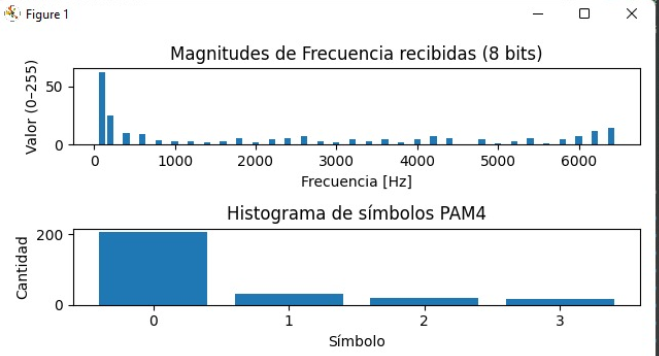

In [ ]:
Vector enviado (68 valores decimales):
[104, 111, 108, 97, 63, 18, 0, 11, 0, 5, 0, 8, 0, 9, 0, 2, 0, 3, 0, 8, 0, 4, 0, 1, 0, 2, 0, 6, 0, 5, 0, 2, 0, 0, 0, 4, 0, 3, 0, 4, 0, 2, 0, 11, 0, 5, 0, 3, 0, 1, 0, 2, 0, 10, 0, 7, 0, 5, 0, 13, 0, 5, 0, 3, 0, 5, 0, 18]


Empaquetado de símbolos PAM4 en bytes:
Símbolos: [1, 2, 2, 0] → Byte: 104 (bin: 01101000)
Símbolos: [1, 2, 3, 3] → Byte: 111 (bin: 01101111)
Símbolos: [1, 2, 3, 0] → Byte: 108 (bin: 01101100)
Símbolos: [1, 2, 0, 1] → Byte: 97 (bin: 01100001)
Símbolos: [0, 3, 3, 3] → Byte: 63 (bin: 00111111)
Símbolos: [0, 1, 0, 2] → Byte: 18 (bin: 00010010)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 2, 3] → Byte: 11 (bin: 00001011)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 1, 1] → Byte: 5 (bin: 00000101)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 2, 0] → Byte: 8 (bin: 00001000)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 2, 1] → Byte: 9 (bin: 00001001)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 2] → Byte: 2 (bin: 00000010)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 3] → Byte: 3 (bin: 00000011)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 2, 0] → Byte: 8 (bin: 00001000)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 1, 0] → Byte: 4 (bin: 00000100)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 1] → Byte: 1 (bin: 00000001)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 2] → Byte: 2 (bin: 00000010)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 1, 2] → Byte: 6 (bin: 00000110)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 1, 1] → Byte: 5 (bin: 00000101)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 2] → Byte: 2 (bin: 00000010)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 1, 0] → Byte: 4 (bin: 00000100)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 3] → Byte: 3 (bin: 00000011)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 1, 0] → Byte: 4 (bin: 00000100)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 2] → Byte: 2 (bin: 00000010)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 2, 3] → Byte: 11 (bin: 00001011)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 1, 1] → Byte: 5 (bin: 00000101)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 3] → Byte: 3 (bin: 00000011)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 1] → Byte: 1 (bin: 00000001)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 2] → Byte: 2 (bin: 00000010)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 2, 2] → Byte: 10 (bin: 00001010)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 1, 3] → Byte: 7 (bin: 00000111)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 1, 1] → Byte: 5 (bin: 00000101)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 3, 1] → Byte: 13 (bin: 00001101)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 1, 1] → Byte: 5 (bin: 00000101)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 0, 3] → Byte: 3 (bin: 00000011)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 0, 1, 1] → Byte: 5 (bin: 00000101)
Símbolos: [0, 0, 0, 0] → Byte: 0 (bin: 00000000)
Símbolos: [0, 1, 0, 2] → Byte: 18 (bin: 00010010)

Cantidad de símbolos PAM4: 272
Enviado 68 bytes a 10.0.0.83:5051
Enviado 68 bytes a 10.0.1.173:8100







##***Canal:***

✅ Arquitectura General
Los dos scripts conforman un sistema distribuido:


Canal_pc_admin.py:
Actúa como PC administradora, encargada de:

Aceptar conexión desde la ESP.
Mostrar información del canal.
Decodificar mensajes PAM4 recibidos.
Activar/desactivar el modo error (introducción de errores en la transmisión).
Proporcionar un menú interactivo para el operador.



Canal_esp.py:
Corre en una ESP32 (MicroPython) y funciona como nodo intermedio del canal:

Recibe paquetes PAM4 desde transmisores.
Decodifica y opcionalmente altera los símbolos (modo error).
Reempaqueta los datos y los reenvía a:

Receptor final.
Monitor (para análisis).


Mantiene conexión persistente con la PC administradora para control.




🔍 Teoría detrás del diseño
1. Modulación PAM4

PAM4 (Pulse Amplitude Modulation 4 niveles):
Cada símbolo puede tomar 4 valores (0, 1, 2, 3), lo que equivale a 2 bits por símbolo.
En el código:

Empaquetado: 4 símbolos → 1 byte (cada símbolo ocupa 2 bits).
Decodificación: Se extraen los 4 símbolos de cada byte usando desplazamientos y máscaras.



Esto permite duplicar la eficiencia respecto a PAM2 (binario), pero aumenta la sensibilidad al ruido.

2. Control Remoto y Modo Error

El modo error simula condiciones adversas del canal:

Se introduce una probabilidad del 5% de alterar símbolos (excepto los primeros 16, que son un prefijo de sincronismo).
Esto permite probar robustez del sistema y algoritmos de corrección.




3. Sincronismo y Prefijo

El código define un prefijo “hola” en PAM4 (16 símbolos) para:

Identificar inicio de paquete.
Protegerlo contra errores (no se altera en modo error).


Esto es clave para alinear la decodificación y evitar pérdida de sincronismo.


4. Conexiones y Persistencia

ESP32 mantiene tres conexiones:

PC administradora (control).
Receptor final (datos).
Monitor (diagnóstico).


Uso de locks para evitar condiciones de carrera en sockets compartidos.
Reconexión automática en caso de fallo → alta disponibilidad.


5. Histograma PAM4

Ambos códigos calculan histogramas de símbolos recibidos:

Permite verificar distribución estadística.
Útil para detectar sesgos o errores sistemáticos.




🔗 Flujo de Datos

Transmisor → ESP32:

Envía bytes PAM4.
ESP decodifica y muestra primeros símbolos.


ESP32 → Receptor y Monitor:

Si modo error activo → altera símbolos.
Reempaqueta y reenvía.


ESP32 → PC Admin:

Reporta estado y eventos.
Recibe comandos (activar/desactivar errores).


PC Admin:

Decodifica mensajes crudos/modulados.
Muestra histogramas y estado del canal.




⚙️ Aspectos Técnicos Clave

Sockets TCP para confiabilidad.
Threads en PC y _thread en ESP para concurrencia.
Protección con locks para evitar inconsistencias.
Persistencia: reconexión automática en caso de caída.
Interfaz CLI en PC para control manual.

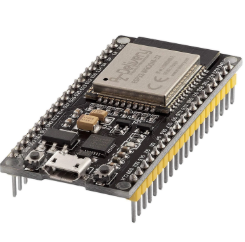

##**Codigo de la PC:**

In [ ]:
import socket
import threading
from collections import Counter

HOST = '0.0.0.0'
CONTROL_PORT = 5050

esp_conn = None
esp_addr = None
esp_lock = threading.Lock()
modo_error = False

# --- Función para decodificar PAM4 desde bytes (2 bits por símbolo) ---
def decodificar_pam4(data_bytes):
    simbolos = []
    for b in data_bytes:
        # Extraer 4 símbolos PAM4 de cada byte
        simbolos.append((b >> 6) & 0b11)  # bits 7-6
        simbolos.append((b >> 4) & 0b11)  # bits 5-4
        simbolos.append((b >> 2) & 0b11)  # bits 3-2
        simbolos.append(b & 0b11)         # bits 1-0
    return simbolos

# --- Hilo que acepta conexiones entrantes desde la ESP ---
def esp_acceptor():
    global esp_conn, esp_addr

    server = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    server.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
    server.bind((HOST, CONTROL_PORT))
    server.listen(1)
    print(f"[ADMIN] Esperando conexión de la ESP en {HOST}:{CONTROL_PORT} ...")

    while True:
        conn, addr = server.accept()
        with esp_lock:
            if esp_conn:
                try:
                    esp_conn.close()
                except:
                    pass
            esp_conn = conn
            esp_addr = addr
        print(f"[ADMIN] ESP conectada desde {addr[0]}:{addr[1]}")
        threading.Thread(target=esp_receiver, args=(conn, addr), daemon=True).start()

# --- Hilo que recibe mensajes desde la ESP ---
def esp_receiver(conn, addr):
    global modo_error
    try:
        while True:
            data = conn.recv(2048)
            if not data:
                break

            lines = data.split(b'\n')
            for line in lines:
                if not line:
                    continue

                if line.startswith(b'CANAL (crudo):'):
                    payload = line[len(b'CANAL (crudo):'):].strip()
                    simbolos = decodificar_pam4(payload)
                    print("\n🛰️ --- MENSAJE DEL CANAL (PAM4 DECODIFICADO) ---")
                    print(simbolos[:50], "..." if len(simbolos) > 50 else "")
                    contar_pam4(simbolos)
                    continue

                if line.startswith(b'CANAL (modulado):'):
                    payload = line[len(b'CANAL (modulado):'):].strip()
                    simbolos = decodificar_pam4(payload)
                    print("\n♻️ --- MENSAJE DEL CANAL (MODULADO PAM4) ---")
                    print(simbolos[:50], "..." if len(simbolos) > 50 else "")
                    contar_pam4(simbolos)
                    continue

                if b'[OK]' in line:
                    print("\n[INFO] Reenvío: ✅ Correcto")
                elif b'[ERROR]' in line:
                    print(f"\n[INFO] Reenvío: ❌ {line.decode(errors='ignore')}")
                elif b'MODO_ERROR_ON' in line:
                    modo_error = True
                    print("[ADMIN] ⚠️ Modo error ACTIVADO")
                elif b'MODO_ERROR_OFF' in line:
                    modo_error = False
                    print("[ADMIN] ✅ Modo error DESACTIVADO")
                else:
                    print(f"\n[INFO] {line.decode(errors='ignore')}")

    except Exception as e:
        print(f"[ERROR] Receiver: {e}")
    finally:
        with esp_lock:
            if esp_conn == conn:
                esp_conn = None
                esp_addr = None
        print(f"[ADMIN] Conexión cerrada desde {addr[0]}")

# --- Función para contar símbolos PAM4 recibidos ---
def contar_pam4(simbolos):
    c = Counter(simbolos)
    print("📊 Histograma PAM4:")
    for i in range(4):
        print(f"  Nivel {i}: {c.get(i, 0)} símbolos")

# --- Función para enviar comandos o mensajes a la ESP ---
def enviar_a_esp(msg):
    with esp_lock:
        if not esp_conn:
            print("No hay ESP conectada.")
            return False
        try:
            esp_conn.sendall((msg + "\n").encode())
            return True
        except Exception as e:
            print("Error enviando a ESP:", e)
            return False

# --- Menú principal ---
def main_menu():
    global modo_error
    while True:
        print("\n--- ADMINISTRADOR ---")
        with esp_lock:
            ip = esp_addr[0] if esp_addr else "NINGUNA"
        print("IP ESP:", ip)
        print("Modo error actual:", "ACTIVADO ✅" if modo_error else "DESACTIVADO ❌")
        print("1) Solicitar INFO de la ESP")
        print("2) Activar MODO ERROR (modificación PAM4)")
        print("3) Desactivar MODO ERROR")
        print("4) Salir")

        op = input("Opción: ").strip()
        if op == "1":
            enviar_a_esp("info")
        elif op == "2":
            modo_error = True
            enviar_a_esp("MODO_ERROR_ON")
            print("[ADMIN] ✅ Modo error ACTIVADO.")
        elif op == "3":
            modo_error = False
            enviar_a_esp("MODO_ERROR_OFF")
            print("[ADMIN] ❌ Modo error DESACTIVADO.")
        elif op == "4":
            break
        else:
            print("Opción inválida.")

# --- Programa principal ---
if __name__ == "__main__":
    threading.Thread(target=esp_acceptor, daemon=True).start()
    main_menu()


##**Código del ESP32:**

In [ ]:
# esp_intermedia_monitor_persistente.py - MicroPython para ESP32 (nodo intermedio con sincronismo PAM4 persistente)

import network
import socket
import time
import _thread
import random

# --- Config WiFi ---
SSID = "UBP"
PASSWORD = "pascal25"

# --- IPs y puertos ---
PC_ADMIN_IP = "10.0.1.66"
CONTROL_PORT = 5050
CHANNEL_PORT = 5051
RECEIVER_IP = "10.0.1.62"
RECEIVER_PORT = 5052
MONITOR_IP = "10.0.1.173"
MONITOR_PORT = 8100

# --- Estados globales ---
pc_sock = None
pc_lock = _thread.allocate_lock()
modo_error = False

# --- Sockets persistentes ---
receiver_sock = None
monitor_sock = None
receiver_lock = _thread.allocate_lock()
monitor_lock = _thread.allocate_lock()

# --- Prefijo "hola" en PAM4 (16 símbolos) ---
PREFIJO_HOLA = [1, 2, 2, 0,
                1, 2, 3, 3,
                1, 2, 3, 0,
                1, 2, 0, 1]

# --- Conexión WiFi ---
wifi = network.WLAN(network.STA_IF)
wifi.active(True)
wifi.connect(SSID, PASSWORD)
print("Conectando a WiFi...")
while not wifi.isconnected():
    time.sleep(0.5)
print("✅ Conectado a WiFi. IP local:", wifi.ifconfig()[0])


# --- Decodificación PAM4 ---
def decodificar_pam4(data):
    simbolos = []
    for b in data:
        simbolos.append((b >> 6) & 0b11)
        simbolos.append((b >> 4) & 0b11)
        simbolos.append((b >> 2) & 0b11)
        simbolos.append(b & 0b11)
    return simbolos


# --- Introducir errores aleatorios (SIEMPRE protegidos los primeros 16 símbolos) ---
def introducir_error(simbolos):
    PROB = 0.05
    total = len(simbolos)

    # Nunca modificar los primeros 16 símbolos del paquete
    limite_protegido = 16 if total >= 16 else total

    for i in range(limite_protegido, total):
        if random.random() < PROB:
            original = simbolos[i]
            opciones = [n for n in (0, 1, 2, 3) if n != original]
            simbolos[i] = random.choice(opciones)
            print(f"⚠️ [ERROR] símbolo {i}: {original} -> {simbolos[i]}")

    return simbolos


# --- Reensamblar símbolos ---
def empaquetar_pam4(simbolos):
    b = bytearray()
    for i in range(0, len(simbolos), 4):
        grupo = simbolos[i:i + 4]
        while len(grupo) < 4:
            grupo.append(0)
        val = (grupo[0] << 6) | (grupo[1] << 4) | (grupo[2] << 2) | grupo[3]
        b.append(val)
    return bytes(b)


# --- Cliente con la PC administradora ---
def pc_control_client():
    global pc_sock, modo_error
    while True:
        try:
            s = socket.socket()
            s.connect((PC_ADMIN_IP, CONTROL_PORT))
            with pc_lock:
                pc_sock = s
            print("🖥️ Conectado con la PC administradora")
            s.sendall(("INFO:ESP_IP=" + wifi.ifconfig()[0] + "\n").encode())

            while True:
                data = s.recv(1024)
                if not data:
                    break
                cmd = data.decode().strip()
                if cmd == "MODO_ERROR_ON":
                    modo_error = True
                    print("[⚠️] Modo error ACTIVADO")
                elif cmd == "MODO_ERROR_OFF":
                    modo_error = False
                    print("[✅] Modo error DESACTIVADO")

        except Exception as e:
            print("[❌] Error conexión con Admin:", e)
        finally:
            try:
                s.close()
            except:
                pass
            with pc_lock:
                pc_sock = None
            time.sleep(5)


# --- Clientes persistentes receptor y monitor ---
def receptor_client():
    global receiver_sock
    while True:
        try:
            print("🔌 Conectando con el receptor...")
            s = socket.socket()
            s.connect((RECEIVER_IP, RECEIVER_PORT))
            with receiver_lock:
                receiver_sock = s
            print("✅ Conectado con el receptor.")
            while True:
                time.sleep(1)

        except Exception as e:
            print("[⚠️] Receptor desconectado:", e)
        finally:
            try:
                s.close()
            except:
                pass
            with receiver_lock:
                receiver_sock = None
            time.sleep(3)


def monitor_client():
    global monitor_sock
    while True:
        try:
            print("📡 Conectando con el monitor...")
            s = socket.socket()
            s.connect((MONITOR_IP, MONITOR_PORT))
            with monitor_lock:
                monitor_sock = s
            print("✅ Conectado con el monitor.")
            while True:
                time.sleep(1)

        except Exception as e:
            print("[⚠️] Monitor desconectado:", e)
        finally:
            try:
                s.close()
            except:
                pass
            with monitor_lock:
                monitor_sock = None
            time.sleep(3)


# --- Enviar datos ---
def enviar_datos_persistentes(msg_bytes):
    global receiver_sock, monitor_sock

    with receiver_lock:
        if receiver_sock:
            try:
                receiver_sock.sendall(msg_bytes)
                print(f"[➡️] Enviado al receptor ({len(msg_bytes)} bytes)")
            except Exception as e:
                print("[⚠️] Error enviando al receptor:", e)
                receiver_sock = None
        else:
            print("[⛔] Receptor no conectado")

    with monitor_lock:
        if monitor_sock:
            try:
                monitor_sock.sendall(msg_bytes)
                print(f"[➡️] Enviado al monitor ({len(msg_bytes)} bytes)")
            except Exception as e:
                print("[⚠️] Error enviando al monitor:", e)
                monitor_sock = None
        else:
            print("[⛔] Monitor no conectado")


# --- Calcular histograma ---
def histograma_pam4(simbolos):
    counts = {0: 0, 1: 0, 2: 0, 3: 0}
    for s in simbolos:
        counts[s] += 1
    total = len(simbolos)
    print(f"\n📊 [HISTOGRAMA PAM4] Total: {total} símbolos")
    for nivel in (0, 1, 2, 3):
        print(f"   Nivel {nivel}: {counts[nivel]}")
    print()


# --- Servidor del canal ---
def canal_server():
    s = socket.socket()
    s.bind(('', CHANNEL_PORT))
    s.listen(5)
    print(f"[📡] Esperando transmisores en puerto {CHANNEL_PORT}...")

    while True:
        try:
            conn, addr = s.accept()
            print("[TX] Conexión desde", addr)
            try:
                data = conn.recv(2048)
                if not data:
                    conn.close()
                    continue

                simbolos = decodificar_pam4(data)
                print(f"[TX] Paquete recibido ({len(simbolos)} símbolos).")

                print("Primeros 16 símbolos recibidos:", simbolos[:16])

                histograma_pam4(simbolos)

                if modo_error:
                    simbolos = introducir_error(simbolos)
                else:
                    print("✅ Modo error desactivado (sin alteraciones).")

                msg_modulado = empaquetar_pam4(simbolos)
                enviar_datos_persistentes(msg_modulado)

                with pc_lock:
                    if pc_sock:
                        pc_sock.sendall(b"[INFO] Paquete PAM4 procesado\n")

            except Exception as e:
                print("[Error canal interno]:", e)
            finally:
                try:
                    conn.close()
                except:
                    pass
        except Exception as e:
            print("[Error aceptando conexión]:", e)
            time.sleep(0.05)


# --- Lanzar hilos ---
_thread.start_new_thread(pc_control_client, ())
_thread.start_new_thread(canal_server, ())
_thread.start_new_thread(receptor_client, ())
_thread.start_new_thread(monitor_client, ())

# --- Mantener vivo ---
while True:
    time.sleep(1)


##Explicacion de los Códigos:

Este código es para un ESP32 programado con MicroPython y actúa como un nodo intermedio en un canal de comunicación.

Funciones principales:

- Configuración inicial:

Se conecta a una red WiFi (SSID y PASSWORD).
Define las direcciones IP y puertos para la comunicación con la PC administradora, el receptor final y un monitor.


- Modulación y Demodulación PAM4:

La función decodificar_pam4 toma bytes y los convierte en una secuencia de símbolos PAM4 (cada byte se divide en 4 símbolos de 2 bits cada uno).
La función empaquetar_pam4 realiza el proceso inverso, tomando una secuencia de símbolos PAM4 y empaquetándolos en bytes para su transmisión.


- Control de Errores (Modo Error):

introducir_error es una función clave para simular un canal ruidoso. Si el modo_error está activado, introduce aleatoriamente un 5% de errores en los símbolos PAM4, cambiando su valor. Es importante destacar que los primeros 16 símbolos (correspondientes al prefijo "hola") están protegidos y nunca se modifican para mantener la sincronización.


- Conexiones Persistentes:

El ESP32 mantiene conexiones persistentes con la PC administradora, el receptor final y un monitor, utilizando hilos separados (_thread.start_new_thread) para cada conexión (pc_control_client, receptor_client, monitor_client).
Esto asegura que, si una conexión se cae, el ESP32 intentará reconectarse automáticamente cada pocos segundos.


- Servidor del Canal (canal_server):

El ESP32 actúa como un servidor que espera datos PAM4 de un transmisor.
Al recibir un paquete, lo decodifica a símbolos PAM4.
Muestra un histograma de los símbolos recibidos.
Si el modo_error está activo, introduce errores en los símbolos.
Luego, reempaqueta los símbolos (potencialmente con errores) y los envía al receptor final y al monitor utilizando la función enviar_datos_persistentes.


- Interacción con la PC Administradora:

La PC puede enviar comandos al ESP32 para activar o desactivar el modo_error.
El ESP32 también envía información y estado a la PC, como su IP y mensajes de que un paquete PAM4 ha sido procesado.
En resumen, este código transforma un ESP32 en un nodo de retransmisión inteligente que puede simular condiciones de canal adversas y monitorear el flujo de datos PAM4, manteniendo una comunicación robusta y persistente con otros sistemas.

#***Receptor***


✅ Arquitectura del Receptor
El receptor está compuesto por:


Receptor_esp.py (ESP32):

Recibe datos crudos desde el CANAL (puerto 5052).
Agrupa los datos en frames de 68 bytes:

Cabecera: 4 bytes ('h','o','l','a').
Datos: 64 amplitudes (0–255).


Reenvía cada frame a la PC receptora mediante una conexión persistente TCP.



Receptor_pc.py (PC):

Escucha en puerto 9100 para recibir frames desde la ESP.
Decodifica los datos en símbolos PAM4.
Muestra cabecera y símbolos por consola.
Reenvía los frames al visualizador (IP fija, puerto 8100).




🔍 Teoría detrás del diseño
1. Formato del Frame

  Cada frame tiene 68 bytes:

  4 bytes de cabecera: sincronismo y validación (hola).
  64 bytes de datos: representan amplitudes (probablemente magnitudes de frecuencias).


  Este diseño asegura:

  Delimitación clara entre frames.
  Protección contra errores (cabecera fija permite detectar desalineación).




2. Decodificación PAM4 en la PC

  Cada byte contiene 4 símbolos PAM4 (2 bits por símbolo).
  La función decodificar_pam4():

  Extrae los 4 símbolos por desplazamiento y máscara.


  Esto permite reconstruir la secuencia original enviada por el transmisor.


3. Conexión Persistente ESP → PC

  La ESP mantiene un socket persistente con la PC:

  Si se rompe, intenta reconectar automáticamente.


  Ventajas:

  Menor latencia (no se establece conexión por cada frame).
  Mayor robustez ante fallos temporales.




4. Buffering y Ensamblado

  La ESP acumula bytes en un buffer (buf) y arma frames completos:

  Evita pérdida de datos si llegan en fragmentos.


  La PC también usa un buffer (bin_buf) para procesar frames completos:

  Garantiza que no se decodifique un frame incompleto.




5. Reenvío al Visualizador

  La PC actúa como hub:

  Decodifica y muestra datos.
  Reenvía frames al visualizador para análisis gráfico.


Implementa reintentos exponenciales para reconectar al visualizador.


🔗 Flujo de Datos

CANAL → ESP32:

Recibe datos crudos.
Agrupa en frames de 68 bytes.


ESP32 → PC:

Envía frames completos por conexión persistente.


PC → Visualizador:

Reenvía los mismos frames para monitoreo.


PC (local):

Decodifica PAM4.
Muestra cabecera y símbolos.




⚙️ Aspectos Técnicos Clave

TCP para confiabilidad.
Persistencia en la conexión ESP → PC.
Timeouts en PC para evitar bloqueos.
Cabecera fija para sincronismo.
Decodificación PAM4 para análisis.
Reintentos con backoff para el visualizador.


🔍 Comparación con el Canal

El canal introduce errores opcionales (modo error), mientras que el receptor:

No altera datos.
Solo reensambla y decodifica.


El receptor trabaja con frames fijos, mientras que el canal maneja paquetes PAM4 más largos.

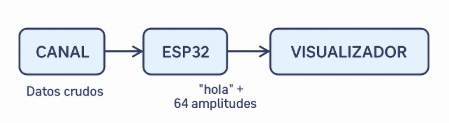

Diagrama conceptual del receptor:

CANAL → ESP32 → VISUALIZADOR
El CANAL envía datos crudos.
La ESP32:

Recibe datos.

Agrupa en frames de 68 bytes: cabecera "hola" + 64 amplitudes.
Reenvía a la PC receptora (que a su vez los manda al visualizador).

##Código de la PC:

In [ ]:
import socket
import time

# PC <-- ESP32
HOST = "0.0.0.0"
PORT = 9100

FRAME_BYTES = 68

# PC --> VISUALIZADOR
VIS_IP   = "10.0.1.173"
VIS_PORT = 8100

def now():
    return time.strftime("%H:%M:%S")

def decodificar_pam4(data_bytes):  #se decodifica en PAM4 los bloques fijos de datos
    simbolos = []
    for b in data_bytes:
        simbolos.append((b >> 6) & 0b11)
        simbolos.append((b >> 4) & 0b11)
        simbolos.append((b >> 2) & 0b11)
        simbolos.append(b & 0b11)
    return simbolos

class VisualizadorConn:
    def __init__(self, host, port):
        self.host = host
        self.port = port
        self.sock = None

    def close(self):
        try:
            if self.sock:
                self.sock.close()
        except:
            pass
        self.sock = None

    def _connect(self):
        self.close()
        s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        s.settimeout(5)
        s.connect((self.host, self.port))
        s.settimeout(None)
        self.sock = s
        print(f"[{now()}] ✅ conectado al visualizador {self.host}:{self.port}")

    def ensure(self):
        if self.sock is not None:
            return
        backoff = [1, 2, 4, 8, 10]
        for t in backoff:
            try:
                self._connect()
                return
            except Exception as e:
                print(f"[{now()}] ⚠ no se pudo conectar al visualizador: {e} (reintento en {t}s)")
                time.sleep(t)
        while True:
            try:
                self._connect()
                return
            except Exception as e:
                print(f"[{now()}] ⚠ reintento visualizador en 10s: {e}")
                time.sleep(10)

    def send_bytes(self, data: bytes):
        if not data:
            return
        try:
            self.ensure()
            self.sock.sendall(data)
            print(f"[{now()}] ▶ reenviado al visualizador ({len(data)}B)")
        except Exception as e:
            print(f"[{now()}] ⚠ error enviando al visualizador: {e}")
            self.close()

def process_frame(frame_bytes: bytes, frame_idx: int, vis: VisualizadorConn):
    if len(frame_bytes) != FRAME_BYTES:
        print(f"[{now()}] ⚠ frame {frame_idx} con tamaño inesperado: {len(frame_bytes)}B")
        return

    header = frame_bytes[:4]   #toma los primeros 4 bytes del bloque fijo (asumimos que es el hola)
    try:
        header_txt = header.decode("latin1")
    except Exception:
        header_txt = repr(list(header))

    print(f"[{now()}] Frame {frame_idx}: cabecera = {header_txt!r}")   #Los muestra por pantalla como cabecera:

    simbolos = decodificar_pam4(frame_bytes)
    print(f"[{now()}] 🧠 Símbolos PAM4 decodificados ({len(simbolos)}):")
    print("   ", simbolos)
    print()

    vis.send_bytes(frame_bytes)

def main():
    frame_idx = 0
    vis = VisualizadorConn(VIS_IP, VIS_PORT)

    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        s.bind((HOST, PORT))
        s.listen(1)
        print(f"[{now()}] PC escuchando a ESP32 en {HOST}:{PORT}")

        while True:
            print(f"[{now()}] ⏳ Esperando conexión de ESP32...")
            conn, addr = s.accept()
            print(f"[{now()}] 🔗 Conectado desde {addr}")

            bin_buf = bytearray()

            with conn:
                conn.settimeout(10)
                while True:
                    try:
                        data = conn.recv(4096)
                    except socket.timeout:
                        print(f"[{now()}] ⏱ Timeout de recepción, cierro conexión y espero otra")
                        break

                    if not data:
                        print(f"[{now()}] ⚠ Conexión cerrada por la ESP32")
                        break

                    bin_buf.extend(data)

                    while len(bin_buf) >= FRAME_BYTES:
                        frame = bytes(bin_buf[:FRAME_BYTES])
                        del bin_buf[:FRAME_BYTES]
                        frame_idx += 1
                        process_frame(frame, frame_idx, vis)

if __name__ == "__main__":
    main()


##Código del ESP32:


In [ ]:
# main.py -- ESP32 Receptor
# Recibe bytes desde el CANAL y reenvía frames de 68 bytes a la PC en streaming.
#
# Formato de cada frame:
#   0..3  -> 'h','o','l','a'   (cabecera)
#   4..67 -> 64 amplitudes 0..255

import network
import usocket as socket
import time

# ========= CONFIG WiFi =========
SSID = "UBP"
PASS = "pascal25"

# ESP32 <-- CANAL (servidor)
IP_RX   = "0.0.0.0"
PORT_RX = 5052           # puerto donde escucha al canal (coincide con RECEIVER_PORT)

# ESP32 --> PC RECEPTORA (cliente persistente)
PC_IP      = "10.0.0.131"   # IPv4 de tu PC receptora
PC_PORT_TX = 9100           # puerto donde escucha tu script de PC

FRAME_BYTES = 68            # "hola" (4) + 64 amplitudes

pc_sock = None  # socket persistente hacia la PC


def wifi_connect():
    sta = network.WLAN(network.STA_IF)
    if not sta.active():
        sta.active(True)
    print("Conectando a WiFi...")
    if not sta.isconnected():
        sta.connect(SSID, PASS)
        t0 = time.ticks_ms()
        while not sta.isconnected():
            if time.ticks_diff(time.ticks_ms(), t0) > 20000:
                raise RuntimeError("Timeout WiFi (revisá SSID/clave)")
            time.sleep_ms(200)
    print("OK WiFi:", sta.ifconfig())


def conectar_pc():
    """Conexión PERSISTENTE ESP32 -> PC. Reintenta hasta lograrlo."""
    global pc_sock
    if pc_sock:
        try:
            pc_sock.close()
        except:
            pass
        pc_sock = None

    while True:
        try:
            s = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            s.settimeout(5)
            s.connect((PC_IP, PC_PORT_TX))
            s.settimeout(None)
            pc_sock = s
            print("✅ Conectado en forma persistente a PC {}:{}".format(PC_IP, PC_PORT_TX))
            return
        except Exception as e:
            print("⚠️ No puedo conectar a PC {}:{} -> {} (reintento en 2s)".format(
                PC_IP, PC_PORT_TX, e
            ))
            try:
                s.close()
            except:
                pass
            time.sleep(2)


def enviar_frame_a_pc_stream(frame_bytes):
    """
    Envía un frame de 68 bytes a la PC usando la conexión persistente.
    Si se rompe la conexión, reconecta y reintenta una vez.
    """
    global pc_sock

    if not pc_sock:
        conectar_pc()

    for intento in range(2):
        try:
            pc_sock.sendall(frame_bytes)
            print("▶ frame (68 bytes) enviado a PC")
            return
        except Exception as e:
            print("⚠️ error enviando a PC:", e)
            try:
                pc_sock.close()
            except:
                pass
            pc_sock = None
            if intento == 0:
                print("🔄 Reintentando conexión con la PC...")
                conectar_pc()
            else:
                print("⛔ No se pudo reenviar el frame a la PC")
                return


def main():
    wifi_connect()
    conectar_pc()  # conexión persistente con la PC

    srv = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    try:
        srv.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
        srv.bind((IP_RX, PORT_RX))
        srv.listen(1)
        print("📡 ESP32 escuchando al CANAL en {}:{}".format(IP_RX, PORT_RX))
        print("↩️  Reenviará frames de 68 bytes a {}:{} (conexión persistente)".format(
            PC_IP, PC_PORT_TX
        ))

        while True:
            print("⏳ Esperando conexión del CANAL...")
            conn, addr = srv.accept()
            print("🔗 Conexión desde {}".format(addr))

            buf = bytearray()

            try:
                # SIN timeout: la conexión con el canal se mantiene
                while True:
                    chunk = conn.recv(1024)
                    if not chunk:
                        print("⚠️ Conexión del canal cerrada por el otro lado")
                        break

                    # acumular bytes crudos del canal
                    buf.extend(chunk)

                    # mientras haya al menos 68 bytes, armar frames completos
                    while len(buf) >= FRAME_BYTES:
                        frame = bytes(buf[:FRAME_BYTES])
                        buf = buf[FRAME_BYTES:]   # mover ventana en el buffer

                        print("🧱 frame crudo(68B):", list(frame))
                        enviar_frame_a_pc_stream(frame)

            except Exception as e:
                print("⚠️ error RX desde el canal:", e)
            finally:
                try:
                    conn.close()
                except:
                    pass
                print("⏹ Conexión con el canal cerrada, esperando otra…")

    finally:
        try:
            srv.close()
        except:
            pass
        if pc_sock:
            try:
                pc_sock.close()
            except:
                pass


if __name__ == "__main__":
    main()


##Explicacion del código:

Este código es para un ESP32 programado con MicroPython y actúa como un nodo intermedio en un canal de comunicación.

Funciones principales:

- Configuración inicial:

Se conecta a una red WiFi (SSID y PASSWORD).
Define las direcciones IP y puertos para la comunicación con la PC administradora, el receptor final y un monitor.

- Conexión Persistente ESP32 -> PC:

La función conectar_pc es crucial aquí. Intenta establecer una conexión TCP persistente con la PC receptora. Si la conexión falla o se rompe en cualquier momento, el ESP32 reintentará automáticamente hasta que se establezca o reestablezca. Esto asegura una comunicación robusta.

- Envío de Frames a la PC:

La función enviar_frame_a_pc_stream toma un frame_bytes (un bloque de 68 bytes) y lo envía a la PC a través de la conexión persistente. Si la conexión se cae durante el envío, intenta reconectarse una vez y reenviar el frame.

- Servidor del Canal (Manejo de Datos del CANAL):

En la función main, el ESP32 se configura como un servidor (srv) que escucha en IP_RX y PORT_RX (puerto 5052) para recibir datos del CANAL (el transmisor).
Cuando el CANAL se conecta, el ESP32 entra en un bucle para recibir fragmentos de datos (chunk).
Los bytes recibidos del CANAL se acumulan en un buf (buffer).
Ensamblado de Frames: A medida que se acumulan datos, el código verifica si hay al menos FRAME_BYTES (68 bytes). Si los hay, extrae el primer frame de 68 bytes del buffer, lo imprime en formato decimal y luego lo envía a la PC usando enviar_frame_a_pc_stream.
El resto del buffer se mantiene para procesar el siguiente frame.

- Manejo de Errores y Cierre:

El código incluye bloques try-except-finally para manejar posibles errores en las comunicaciones y asegurar que los sockets se cierren correctamente cuando ya no se necesitan o cuando el programa finaliza.
En resumen, este código convierte el ESP32 en un receptor que se conecta a una red WiFi, escucha datos brutos de un 'CANAL', los agrupa en frames de 68 bytes y los reenvía de forma persistente a una PC receptora, garantizando la fiabilidad de la conexión incluso si hay fallos temporales.




#***Monitor***



In [ ]:
✅ Rol del Monitor
Este script implementa un visualizador avanzado que:

Recibe datos desde múltiples transmisores (TX1, TX2, TX3).
Decodifica símbolos PAM4 y reconstruye magnitudes.
Ofrece interfaz gráfica interactiva con PyQt6 y PyQtGraph.
Realiza reconstrucción temporal de la señal mediante IFFT (similar al transmisor).


🔍 Componentes Clave
1. Servidor TCP

Escucha en puerto 8100.
Acepta múltiples clientes (hasta 8 conexiones).
Asigna etiquetas TX1, TX2, TX3 según IP.
Recibe datos en bytes, los convierte a símbolos PAM4:
Pythonunpack_bytes_to_symbols(data_bytes)Mostrar más líneas

Mantiene un buffer circular para cada transmisor (máx. 10,000 símbolos).


2. Decodificación y Sincronismo

Cabecera fija: HEADER_SYMBOLS = [1,2,2,0,1,2,3,3,1,2,3,0,1,2,0,1].
Busca la última cabecera válida en el buffer:
Pythonfind_latest_valid_frame(symbols)Mostrar más líneas

Extrae 256 símbolos PAM4 → reconstruye 64 valores de 8 bits (magnitudes):
Pythondecode_256_symbols_to_64_8bit(values)Mostrar más líneas


Esto asegura alineación correcta y evita errores por desincronización.

3. Reconstrucción IFFT

Cada frame decodificado (64 magnitudes) se convierte en una señal temporal:

Frecuencias: 100 Hz a 6400 Hz (64 bins).
Duración: 0.1 s.
Muestreo: 44.1 kHz.


Se genera un espectro con amplitudes en posiciones correspondientes y se aplica:
Pythonnp.fft.ifft(spectrum).realMostrar más líneas

Resultado: onda reconstruida para análisis en tiempo.


4. Interfaz Gráfica

Pestañas principales:

Tiempo: muestra secuencia de símbolos o voltajes.
PAM4 Values: histograma o secuencia de niveles.
Magnitudes 64: barras para cada frecuencia.
Reconstrucción (IFFT): señal temporal reconstruida.
Raw Data: símbolos PAM4 en hex.
Bit Stream: flujo de bits decodificados.
Header Sync: estado de sincronismo.
Decoded Bins: valores 0–255 decodificados.

Ventanas flotantes:

Chat / Log.
Capas (activar/desactivar TX).


5. Visualización Avanzada

PyQtGraph para gráficos en tiempo real.
Color configurable por transmisor.
Filtros: ignorar cabecera, demodulación opcional.
Histograma dinámico para distribución de símbolos.


🔗 Flujo de Datos

Monitor recibe bytes desde ESP (o PC intermediaria).
Convierte a símbolos PAM4.
Actualiza:

Gráficos en tiempo real.
Buffers para sincronismo.

Si detecta cabecera:

Decodifica magnitudes.
Reconstruye señal con IFFT.
Actualiza pestañas correspondientes.


⚙️ Aspectos Técnicos Clave

Multithreading para servidor y GUI.
Buffers circulares para eficiencia.
Reconexión automática en caso de error.
Optimización gráfica (antialias, colores dinámicos).
Escalabilidad: soporta hasta 3 transmisores simultáneos.


🔍 Comparación con Canal y Receptor

El canal introduce errores y reenvía datos.
El receptor agrupa frames y decodifica PAM4.
El monitor:

No altera datos.
Se enfoca en análisis visual, sincronismo y reconstrucción temporal.

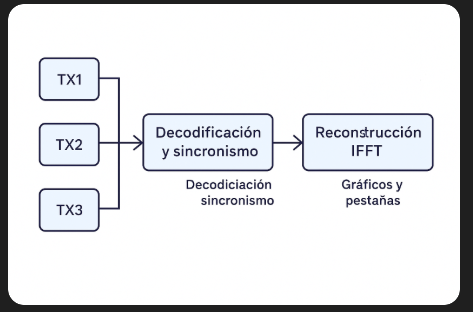

**Diagrama conceptual del monitor:**

- Entradas: TX1, TX2, TX3 (cada transmisor envía símbolos PAM4).
- Procesos:

   -Decodificación y sincronismo: busca cabecera, reconstruye magnitudes.
   
   -Reconstrucción IFFT: genera señal temporal.


- Salidas:

   -Gráficos en tiempo real.

   -Pestañas interactivas (magnitudes, histograma, bitstream, señal reconstruida).

##Código del Monitor:

In [ ]:
# ==========================
# VISUALIZADOR V2.2 (Con Reconstrucción en Tiempo IFFT)
# ==========================
import sys
import socket
import threading
import traceback
from collections import deque
from datetime import datetime

import numpy as np
from PyQt6 import QtCore, QtWidgets, QtGui
import pyqtgraph as pg

# ------------------------- # Configuración # -------------------------
HEADER_SYMBOLS = [1, 2, 2, 0, 1, 2, 3, 3, 1, 2, 3, 0, 1, 2, 0, 1]

# ------------------------- # Utilities & Decoder # -------------------------
def pam_symbols_to_voltage(vals):
    arr = np.array(vals, dtype=float)
    if arr.size == 0: return arr
    if np.nanmax(arr) <= 3:
        map4 = {0: -3.0, 1: -1.0, 2: 1.0, 3: 3.0}
        return np.array([map4.get(int(round(v)), 0.0) for v in arr], dtype=float)
    return ((arr / 7.0) * 6.0) - 3.0

def decode_256_symbols_to_64_8bit(values):
    if len(values) < 256: return []
    syms = values[:256]
    bitstr = ''.join(format(int(s) & 0x3, '02b') for s in syms)
    bins = []
    for i in range(64):
        chunk = bitstr[i*8:(i+1)*8]
        if len(chunk) < 8: chunk = chunk.ljust(8, '0')
        bins.append(int(chunk, 2))
    return bins

def find_latest_valid_frame(symbols):
    sym_list = list(symbols)
    h_len = len(HEADER_SYMBOLS)
    t_len = h_len + 256
    for i in range(len(sym_list) - t_len, -1, -1):
        if sym_list[i] == HEADER_SYMBOLS[0]:
            if sym_list[i : i+h_len] == HEADER_SYMBOLS:
                return decode_256_symbols_to_64_8bit(sym_list[i+h_len : i+t_len]), i
    return None, -1

def unpack_bytes_to_symbols(data_bytes):
    symbols = []
    for b in data_bytes:
        byte = int(b) & 0xFF
        symbols.extend([(byte >> 6) & 0x3, (byte >> 4) & 0x3, (byte >> 2) & 0x3, byte & 0x3])
    return symbols

# ------------------------- # Server Thread # -------------------------
class ServerThread(QtCore.QThread):
    status = QtCore.pyqtSignal(str)
    ip_assigned = QtCore.pyqtSignal(str, str)
    message_text = QtCore.pyqtSignal(str, str, str)
    message_raw = QtCore.pyqtSignal(str, str, list, int)
    buffer_update = QtCore.pyqtSignal(str, str, list)

    def __init__(self, port=8100, parent=None):
        super().__init__(parent)
        self.port = int(port)
        self._stop_event = threading.Event()
        self.sock = None
        self.ip_to_tx = {}
        self.lock = threading.Lock()
        self.active_clients = []
        self.clients_lock = threading.Lock()

    def stop(self):
        self._stop_event.set()
        try:
            if self.sock: self.sock.close()
        except: pass
        with self.clients_lock:
            for conn in self.active_clients:
                try: conn.close()
                except: pass

    def assign_tx_for_ip(self, ip):
        with self.lock:
            if ip in self.ip_to_tx: return self.ip_to_tx[ip], False
            used = set(self.ip_to_tx.values())
            for tx in ("TX1", "TX2", "TX3"):
                if tx not in used:
                    self.ip_to_tx[ip] = tx
                    return tx, True
            self.ip_to_tx[ip] = "TX1"
            return "TX1", True

    def run(self):
        try:
            self.sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
            self.sock.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
            self.sock.bind(("0.0.0.0", self.port))
            self.sock.listen(8)
            self.sock.settimeout(1.0)
            self.status.emit(f"Escuchando en {self.port}")
        except Exception as e:
            self.status.emit(f"Error inicio: {e}"); return
        while not self._stop_event.is_set():
            try: conn, addr = self.sock.accept()
            except socket.timeout: continue
            except: break
            ip = addr[0]; tx, newly = self.assign_tx_for_ip(ip)
            if newly: self.ip_assigned.emit(tx, ip)
            with self.clients_lock: self.active_clients.append(conn)
            threading.Thread(target=self.client_handler, args=(conn, ip, tx), daemon=True).start()

    def client_handler(self, conn, ip, tx):
        self.status.emit(f"Conectado {ip}->{tx}")
        conn.settimeout(2.0)
        client_buffer = deque(maxlen=10000)
        try:
            while not self._stop_event.is_set():
                try: data = conn.recv(4096)
                except socket.timeout: continue
                except: break
                if not data: break
                symbols = unpack_bytes_to_symbols(list(data))
                if symbols: self.message_raw.emit(tx, ip, list(symbols[:50]), len(symbols))
                client_buffer.extend(symbols)
                self.buffer_update.emit(tx, ip, list(client_buffer))
        finally:
            with self.clients_lock:
                if conn in self.active_clients: self.active_clients.remove(conn)
            try: conn.close()
            except: pass
            self.status.emit(f"Desconectado {ip}")

# ------------------------- # Ventanas Flotantes # -------------------------
class ChatWindow(QtWidgets.QWidget):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("💬 Chat / Log")
        self.resize(500, 600)
        l = QtWidgets.QVBoxLayout(self)
        self.chat = QtWidgets.QTextEdit(); self.chat.setReadOnly(True)
        self.chat.setStyleSheet("background:#1a1a1a; color:#e0e0e0; font-family:Segoe UI; font-size:9pt;")
        self.log = QtWidgets.QTextEdit(); self.log.setReadOnly(True)
        self.log.setStyleSheet("background:#000; color:#90ee90; font-family:Consolas; font-size:8pt;")
        l.addWidget(QtWidgets.QLabel("Mensajes:", styleSheet="font-weight:bold; color:#add8e6;")); l.addWidget(self.chat, 2)
        l.addWidget(QtWidgets.QLabel("Sistema:", styleSheet="font-weight:bold; color:#ffebcd;")); l.addWidget(self.log, 1)
    def add_c(self, t): self.chat.append(f"[{datetime.now().strftime('%H:%M:%S')}] {t}"); self.chat.verticalScrollBar().setValue(self.chat.verticalScrollBar().maximum())
    def add_l(self, t): self.log.append(f"[{datetime.now().strftime('%H:%M:%S')}] {t}"); self.log.verticalScrollBar().setValue(self.log.verticalScrollBar().maximum())

class LayersWindow(QtWidgets.QWidget):
    def __init__(self, tx_c, cb):
        super().__init__(); self.setWindowTitle("🗂 Capas"); self.setWindowFlags(QtCore.Qt.WindowType.WindowStaysOnTopHint)
        l = QtWidgets.QVBoxLayout(self); self.cbs = {}
        for tx in ["TX1","TX2","TX3"]:
            c = QtWidgets.QCheckBox(tx); c.setChecked(True); c.setStyleSheet(f"color:{tx_c.get(tx,'#fff')}; font-weight:bold;")
            c.toggled.connect(lambda s,t=tx: cb(t,s)); l.addWidget(c); self.cbs[tx] = c
    def upd_c(self, tx_c):
        for tx, c in self.cbs.items(): c.setStyleSheet(f"color:{tx_c.get(tx,'#fff')}; font-weight:bold;")

# ------------------------- # Pestaña Reconstrucción IFFT (NUEVA) # -------------------------
class ReconstructedSignalTab(QtWidgets.QWidget):
    def __init__(self, get_c, is_v, get_n):
        super().__init__()
        self.get_c, self.is_v, self.get_n = get_c, is_v, get_n
        layout = QtWidgets.QVBoxLayout(self)
        self.plots, self.curves = {}, {}
        # Creamos 3 gráficos apilados
        for tx in ["TX1", "TX2", "TX3"]:
            p = pg.PlotWidget(title=f"Señal Reconstruida {tx}")
            p.setBackground('k'); p.showGrid(x=True, y=True, alpha=0.3)
            p.setLabel('bottom', 'Tiempo (s)'); p.setLabel('left', 'Amplitud')
            p.setXRange(0, 0.020) # Zoom inicial de 20ms como solicitado
            layout.addWidget(p)
            self.plots[tx] = p
            self.curves[tx] = p.plot(pen=pg.mkPen(self.get_c(tx), width=2))

    def update_signal(self, tx, bins):
        if not self.is_v(tx):
             self.curves[tx].clear(); return

        # --- Reconstrucción IFFT (igual al Transmisor) ---
        fs = 44100; dur = 0.1; N = int(fs * dur)
        spectrum = np.zeros(N, dtype=complex)
        for i, amp in enumerate(bins):
            freq = (i + 1) * 100
            idx = int(freq * dur)
            if idx < N: spectrum[idx] = float(amp) + 0j

        signal = np.fft.ifft(spectrum).real
        t = np.linspace(0, dur, N, endpoint=False)
        # -------------------------------------------------

        c = QtGui.QColor(self.get_c(tx))
        self.curves[tx].setPen(pg.mkPen(c, width=2))
        self.curves[tx].setData(t, signal)
        # Actualizar título con nombre si cambió
        self.plots[tx].setTitle(f"Señal Reconstruida {self.get_n(tx)}")

# ------------------------- # Otras Pestañas # -------------------------
class PAM4ValuesTab(QtWidgets.QWidget):
    def __init__(self, gc, iv, gn):
        super().__init__(); self.gc, self.iv = gc, iv
        self.v = {t:deque(maxlen=2000) for t in ["TX1","TX2","TX3"]}; self.c = {t:[0]*8 for t in ["TX1","TX2","TX3"]}
        self.m = QtWidgets.QComboBox(); self.m.addItems(["Secuencia","Histograma"]); self.m.currentTextChanged.connect(lambda:self.upd())
        b = QtWidgets.QPushButton("Reset"); b.clicked.connect(self.rst)
        h = QtWidgets.QHBoxLayout(); h.addWidget(QtWidgets.QLabel("Modo:")); h.addWidget(self.m); h.addStretch(); h.addWidget(b)
        self.p = pg.PlotWidget(); self.p.setBackground('k'); self.p.showGrid(x=True,y=True,alpha=0.3)
        l = QtWidgets.QVBoxLayout(self); l.addLayout(h); l.addWidget(self.p)
    def rst(self):
        for t in self.v: self.v[t].clear(); self.c[t] = [0]*8
        self.upd()
    def add(self, tx, val):
        vi = max(0, min(7, int(val))); self.v[tx].append(vi); self.c[tx][vi] += 1
        self.upd()
    def upd(self):
        try:
            self.p.clear(); mo = self.m.currentText(); o = {"TX1":-0.2,"TX2":0,"TX3":0.2}
            for tx in ["TX1","TX2","TX3"]:
                if not self.iv(tx): continue
                qc = QtGui.QColor(self.gc(tx)); c = (qc.red(),qc.green(),qc.blue())
                if "Histo" in mo: self.p.addItem(pg.BarGraphItem(x=np.arange(8)+o[tx], height=self.c[tx], width=0.15, brush=pg.mkBrush(c+(200,))))
                else:
                    d = list(self.v[tx]); N=len(d); M=min(300,N)
                    if M>0: x=np.arange(N-M,N)+o[tx]; self.p.addItem(pg.ScatterPlotItem(x, np.array(d[-M:]), size=6, brush=pg.mkBrush(c)))
        except: pass

class MagnitudesTab(QtWidgets.QWidget):
    def __init__(self, gc, iv, gn):
        super().__init__(); self.gc, self.iv = gc, iv
        self.l = {t:np.zeros(64) for t in ["TX1","TX2","TX3"]}
        self.p = pg.PlotWidget(); self.p.setBackground('k'); self.p.showGrid(x=True,y=True,alpha=0.2)
        self.p.setLabel('bottom','Índice Frec (0-63)'); self.p.setYRange(0,260); self.p.setXRange(-1,65)
        self.p.getAxis('bottom').setTickSpacing(5,1)
        l = QtWidgets.QVBoxLayout(self); l.addWidget(self.p)
    def upd(self, tx, d): self.l[tx] = np.array(d, dtype=float); self.ref()
    def ref(self):
        self.p.clear(); idx = np.arange(64); o = {"TX1":-0.3,"TX2":0,"TX3":0.3}
        for tx in ["TX1","TX2","TX3"]:
            if self.iv(tx):
                c = QtGui.QColor(self.gc(tx))
                self.p.addItem(pg.BarGraphItem(x=idx+o[tx], height=self.l[tx], width=0.28, brush=pg.mkBrush(c.red(),c.green(),c.blue(),230)))

class TextDumpTab(QtWidgets.QWidget): # Para Raw, Bits, Bins (misma lógica base)
    def __init__(self, title):
        super().__init__()
        l = QtWidgets.QVBoxLayout(self); l.addWidget(QtWidgets.QLabel(title))
        self.t = QtWidgets.QTextEdit(); self.t.setReadOnly(True); self.t.setFont(QtGui.QFont("Consolas",9))
        self.t.setLineWrapMode(QtWidgets.QTextEdit.LineWrapMode.WidgetWidth)
        l.addWidget(self.t); self.d = {t:deque(maxlen=2000) for t in ["TX1","TX2","TX3"]}
        self.tm = QtCore.QTimer(self); self.tm.timeout.connect(self.ref); self.tm.start(500)
    def add(self, tx, data): self.d[tx].extend(data)
    def set_d(self, tx, data): self.d[tx] = data # Para bins que reemplazan todo
    def ref(self): pass # Implementado en subclases

class RawDataTab(TextDumpTab):
    def __init__(self): super().__init__("Símbolos PAM4 RAW (HEX):")
    def ref(self):
        txt = []
        for tx in ["TX1","TX2","TX3"]:
            if self.d[tx]: txt.append(f"--- {tx} ---\n{''.join(f'{s:X}' for s in list(self.d[tx])[-400:])}\n\n")
        self.t.setText("".join(txt))

class BitStreamTab(TextDumpTab):
    def __init__(self): super().__init__("Bits Demodulados:")
    def ref(self):
        txt = []
        for tx in ["TX1","TX2","TX3"]:
            if self.d[tx]:
                bits = ''.join(f'{int(v)&3:02b}' for v in list(self.d[tx])[-600:])
                txt.append(f"--- {tx} ---\n{' '.join(bits[i:i+8] for i in range(0,len(bits),8))}\n\n")
        self.t.setText("".join(txt))

class DecodedBinsTab(TextDumpTab):
    def __init__(self): super().__init__("Bins Decodificados (0-255):")
    def add(self, tx, data): self.d[tx] = data # Override para guardar solo el último frame
    def ref(self):
        txt = []
        for tx in ["TX1","TX2","TX3"]:
            if self.d[tx] and len(self.d[tx])==64:
                txt.append(f"--- {tx} ---\n[{', '.join(f'{b:3d}' for b in self.d[tx])}]\n\n")
        self.t.setText("".join(txt))

class HeaderSyncTab(QtWidgets.QWidget):
    def __init__(self):
        super().__init__()
        l = QtWidgets.QVBoxLayout(self); self.lbls = {}
        for tx in ["TX1","TX2","TX3"]:
            lb = QtWidgets.QLabel(f"{tx}: Esperando..."); lb.setStyleSheet("color:gray; font-size:11pt;")
            l.addWidget(lb); self.lbls[tx] = lb
        self.t = QtWidgets.QTextEdit(); self.t.setReadOnly(True); self.t.setFont(QtGui.QFont("Consolas",9))
        l.addWidget(QtWidgets.QLabel("Buffer cerca de cabecera:")); l.addWidget(self.t)
        self.buf = {t:deque(maxlen=1000) for t in ["TX1","TX2","TX3"]}
        self.tm = QtCore.QTimer(self); self.tm.timeout.connect(self.ref); self.tm.start(500)
    def add(self, tx, d): self.buf[tx].extend(d)
    def ref(self):
        txt = []
        for tx in ["TX1","TX2","TX3"]:
            s = list(self.buf[tx])
            if not s: continue
            _, idx = find_latest_valid_frame(s)
            if idx >= 0:
                self.lbls[tx].setText(f"{tx}: ¡SYNC OK! (idx {idx})"); self.lbls[tx].setStyleSheet("color:#90ee90; font-weight:bold; font-size:11pt;")
                start=max(0,idx-8); end=min(len(s),idx+24); frag=s[start:end]
                marked = [(f"[{v}]" if idx<=start+i<idx+16 else str(v)) for i,v in enumerate(frag)]
                txt.append(f"{tx} SYNC:\n... {' '.join(marked)} ...\n\n")
            else:
                self.lbls[tx].setText(f"{tx}: Buscando..."); self.lbls[tx].setStyleSheet("color:orange; font-size:11pt;")
        self.t.setText("".join(txt))

# ------------------------- # MainWindow # -------------------------
class MainWindow(QtWidgets.QMainWindow):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("Analizador Triple V2.2 - Full + IFFT")
        self.resize(1400, 950)
        self.tc = {"TX1":"#f00","TX2":"#0f0","TX3":"#0af"}
        self.tv = {"TX1":True,"TX2":True,"TX3":True}
        self.tn = {"TX1":"TX1","TX2":"TX2","TX3":"TX3"}

        w = QtWidgets.QWidget(); self.setCentralWidget(w); ml = QtWidgets.QVBoxLayout(w)
        top = QtWidgets.QHBoxLayout(); ml.addLayout(top)
        for tx in ["TX1","TX2","TX3"]:
            g = QtWidgets.QGroupBox(tx); g.setStyleSheet(f"QGroupBox{{font-weight:bold; color:{self.tc[tx]};}}"); gl = QtWidgets.QVBoxLayout(g); top.addWidget(g)
            h1=QtWidgets.QHBoxLayout(); h1.addWidget(QtWidgets.QLabel("Nom:")); le=QtWidgets.QLineEdit(self.tn[tx]); le.editingFinished.connect(lambda t=tx,e=le:self.sn(t,e.text())); h1.addWidget(le); gl.addLayout(h1)
            l_ip=QtWidgets.QLabel("IP: -"); gl.addWidget(l_ip); setattr(self,f"ip_{tx}",l_ip)
            h2=QtWidgets.QHBoxLayout(); bc=QtWidgets.QPushButton("Color"); bc.clicked.connect(lambda _,t=tx:self.sc(t)); h2.addWidget(bc)
            cv=QtWidgets.QCheckBox("Ver"); cv.setChecked(True); cv.toggled.connect(lambda s,t=tx:self.sv(t,s)); h2.addWidget(cv); gl.addLayout(h2)

        cl = QtWidgets.QHBoxLayout(); ml.addLayout(cl)
        self.dm=QtWidgets.QCheckBox("Demod TX1"); self.dm.setChecked(True); cl.addWidget(self.dm); cl.addStretch()
        cl.addWidget(QtWidgets.QLabel("Puerto:")); self.sp=QtWidgets.QSpinBox(); self.sp.setRange(1,65535); self.sp.setValue(8100); cl.addWidget(self.sp)
        self.b1=QtWidgets.QPushButton("▶ Inicio"); self.b1.clicked.connect(self.start); cl.addWidget(self.b1)
        self.b2=QtWidgets.QPushButton("⏹ Stop"); self.b2.setEnabled(False); self.b2.clicked.connect(self.stop); cl.addWidget(self.b2)
        self.fc=QtWidgets.QCheckBox("IGNORAR 'hola'"); cl.addWidget(self.fc); cl.addStretch()
        b_ch=QtWidgets.QPushButton("💬 Chat"); b_ch.clicked.connect(lambda:self.chat.show()); cl.addWidget(b_ch)
        b_ly=QtWidgets.QPushButton("🗂 Capas"); b_ly.clicked.connect(lambda:self.lay.show()); cl.addWidget(b_ly)

        self.tabs = QtWidgets.QTabWidget(); ml.addWidget(self.tabs)
        self.t_ti = pg.PlotWidget(); self.t_ti.showGrid(x=True,y=True,alpha=0.3); self.tabs.addTab(self.t_ti,"Tiempo")
        self.curv = {tx: self.t_ti.plot(pen=pg.mkPen(self.tc[tx], width=2), name=tx) for tx in self.tc}

        self.tb_pam = PAM4ValuesTab(self.gc,self.gv,self.gn); self.tabs.addTab(self.tb_pam,"PAM4 Values")
        self.tb_mag = MagnitudesTab(self.gc,self.gv,self.gn); self.tabs.addTab(self.tb_mag,"Magnitudes 64")
        self.tb_rec = ReconstructedSignalTab(self.gc,self.gv,self.gn); self.tabs.addTab(self.tb_rec,"Reconstrucción (IFFT)") # NUEVA PESTAÑA
        self.tb_raw = RawDataTab(); self.tabs.addTab(self.tb_raw,"Raw Data")
        self.tb_bit = BitStreamTab(); self.tabs.addTab(self.tb_bit,"Bit Stream")
        self.tb_syn = HeaderSyncTab(); self.tabs.addTab(self.tb_syn,"Header Sync")
        self.tb_bin = DecodedBinsTab(); self.tabs.addTab(self.tb_bin,"Decoded Bins")

        self.chat = ChatWindow(); self.lay = LayersWindow(self.tc, self.sv_lay); self.srv = None

    def gc(self,t): return self.tc.get(t,"#fff")
    def gv(self,t): return self.tv.get(t,True)
    def gn(self,t): return self.tn.get(t,t)
    def sn(self,t,n): self.tn[t]=n
    def sc(self,t):
        c = QtWidgets.QColorDialog.getColor()
        if c.isValid():
            self.tc[t]=c.name(); self.curv[t].setPen(c.name(),width=2); self.lay.upd_c(self.tc)
            self.tb_pam.upd(); self.tb_mag.ref()
            # Actualizar color de grupo
            for i in range(self.centralWidget().layout().itemAt(0).layout().count()):
                 it = self.centralWidget().layout().itemAt(0).layout().itemAt(i)
                 if it.widget() and isinstance(it.widget(),QtWidgets.QGroupBox) and it.widget().title()==t:
                     it.widget().setStyleSheet(f"QGroupBox{{font-weight:bold; color:{c.name()};}}")
    def sv(self,t,s): self.tv[t]=s; self.curv[t].setVisible(s); self.tb_pam.upd(); self.tb_mag.ref();
    def sv_lay(self,t,s): self.sv(t,s) # Simplificado, actualizar checkbox principal si se quiere perfección

    def start(self):
        if self.srv: return
        self.srv = ServerThread(self.sp.value())
        self.srv.status.connect(self.chat.add_l); self.srv.ip_assigned.connect(self.on_ip)
        self.srv.message_text.connect(lambda t,i,x: self.chat.add_c(f"[{self.gn(t)}] {x}"))
        self.srv.buffer_update.connect(self.on_data)
        self.srv.start(); self.b1.setEnabled(False); self.b2.setEnabled(True)
    def stop(self):
        if self.srv: self.srv.stop(); self.srv.wait(3000); self.srv = None
        self.b1.setEnabled(True); self.b2.setEnabled(False); self.chat.add_l("Servidor detenido")
    @QtCore.pyqtSlot(str,str)
    def on_ip(self,t,i): getattr(self,f"ip_{t}").setText(f"IP: {i}"); self.chat.add_l(f"Asignado {t}->{i}")
    @QtCore.pyqtSlot(str,str,list)
    def on_data(self, tx, ip, syms):
        arr = np.array(syms, dtype=float); disp = arr[-1000:] if arr.size>1000 else arr
        y = pam_symbols_to_voltage(disp) if (tx=="TX1" and self.dm.isChecked()) else disp
        if self.tv[tx]: self.curv[tx].setData(y)
        else: self.curv[tx].clear()

        self.tb_raw.add(tx, syms); self.tb_bit.add(tx, syms); self.tb_syn.add(tx, syms)
        if syms: self.tb_pam.add(tx, syms[-1])

        bins, _ = find_latest_valid_frame(syms)
        if bins:
            self.tb_mag.upd(tx, bins); self.tb_bin.add(tx, bins)
            self.tb_rec.update_signal(tx, bins) # Actualizar señal reconstruida
        elif self.fc.isChecked() and len(syms)>=256:
            fb = decode_256_symbols_to_64_8bit(syms[-256:])
            self.tb_mag.upd(tx, fb); self.tb_bin.add(tx, fb); self.tb_rec.update_signal(tx, fb)
    def closeEvent(self,e): self.stop(); self.chat.close(); self.lay.close(); e.accept()

if __name__ == "__main__":
    app = QtWidgets.QApplication(sys.argv); pg.setConfigOptions(antialias=True, background='k', foreground='w')
    win = MainWindow(); win.show(); sys.exit(app.exec())


##Explicacion del Código:

Este código Python implementa una aplicación de "Monitor" diseñada para recibir, decodificar y visualizar datos de múltiples transmisores (TX1, TX2, TX3) en tiempo real.

Componentes y funcionalidades principales:

- Configuración y Utilidades:

  Define una secuencia de HEADER_SYMBOLS (símbolos de cabecera) que se utiliza para la sincronización de los frames de datos.

  **pam_symbols_to_voltage**: Convierte los símbolos PAM4 (0-3) a voltajes correspondientes (-3V a 3V).

  **decode_256_symbols_to_64_8bit**: Decodifica 256 símbolos PAM4 para reconstruir 64 valores de 8 bits, que representan magnitudes de frecuencia.

  **find_latest_valid_frame**: Busca la cabecera en el flujo de símbolos y extrae el último frame válido, decodificándolo a 64 magnitudes de 8 bits.

  **unpack_bytes_to_symbols**: Desempaqueta bytes crudos en una secuencia de símbolos PAM4 (4 símbolos por byte).


- Servidor TCP (ServerThread):

  Escucha conexiones entrantes en el puerto 8100. Puede manejar múltiples clientes simultáneamente (hasta 8).

  Asigna etiquetas de transmisor (TX1, TX2, TX3) a las direcciones IP de los clientes, intentando asignar de forma rotatoria.

  Recibe datos en bytes de los clientes, los convierte a símbolos PAM4 y los añade a un búfer circular (deque) para cada cliente.

  Emite señales para actualizar el estado, asignar IPs y enviar datos procesados a la interfaz gráfica.

- Interfaz Gráfica (PyQt6 y PyQtGraph):

  La aplicación principal (MainWindow) organiza la interfaz con pestañas y ventanas flotantes.

- Pestañas de Visualización:

  **Tiempo**: Muestra la secuencia de símbolos PAM4 o voltajes en tiempo real.
  PAM4 Values: Presenta un histograma o secuencia de los niveles de los símbolos PAM4.

  **Magnitudes 64**: Muestra gráficos de barras para los 64 valores de magnitud de 8 bits decodificados (corresponden a bins de frecuencia).

  **Reconstrucción (IFFT**): Novedad Toma los 64 valores de magnitud y utiliza una Transformada Inversa de Fourier (IFFT) para reconstruir y mostrar una señal de tiempo simulada, similar a cómo se haría en un transmisor.

  **Raw Data**: Muestra los símbolos PAM4 recibidos en formato hexadecimal.

  **Bit Stream**: Muestra el flujo de bits demodulados.

  **Header Sync**: Muestra el estado de sincronización de la cabecera para cada transmisor y fragmentos del búfer cercanos a la cabecera.

  **Decoded Bins**: Muestra los 64 valores de 8 bits decodificados.

- Ventanas Flotantes:

  **Chat / Log**: Para mensajes del sistema y registros.

  **Capas**: Permite activar/desactivar la visibilidad de cada transmisor en los gráficos.


- Flujo de Datos y Procesamiento en la GUI:

  Cuando el servidor recibe datos, se actualizan los búferes y se intentan decodificar los frames.

  Si se detecta una cabecera y se decodifican las 64 magnitudes de 8 bits, estas se usan para actualizar las pestañas de "Magnitudes 64", "Decoded Bins" y "Reconstrucción (IFFT)".

  También se puede forzar la decodificación de los últimos 256 símbolos si se activa la opción de "IGNORAR 'hola'", lo cual es útil para escenarios donde la cabecera no está presente o se ignora.

En resumen, este monitor es una herramienta avanzada para analizar el flujo de datos PAM4 en un sistema multicanal, ofreciendo diversas perspectivas desde los símbolos crudos hasta la reconstrucción de la señal en tiempo y el análisis de sus componentes de frecuencia.

##**Visualizaciones:**

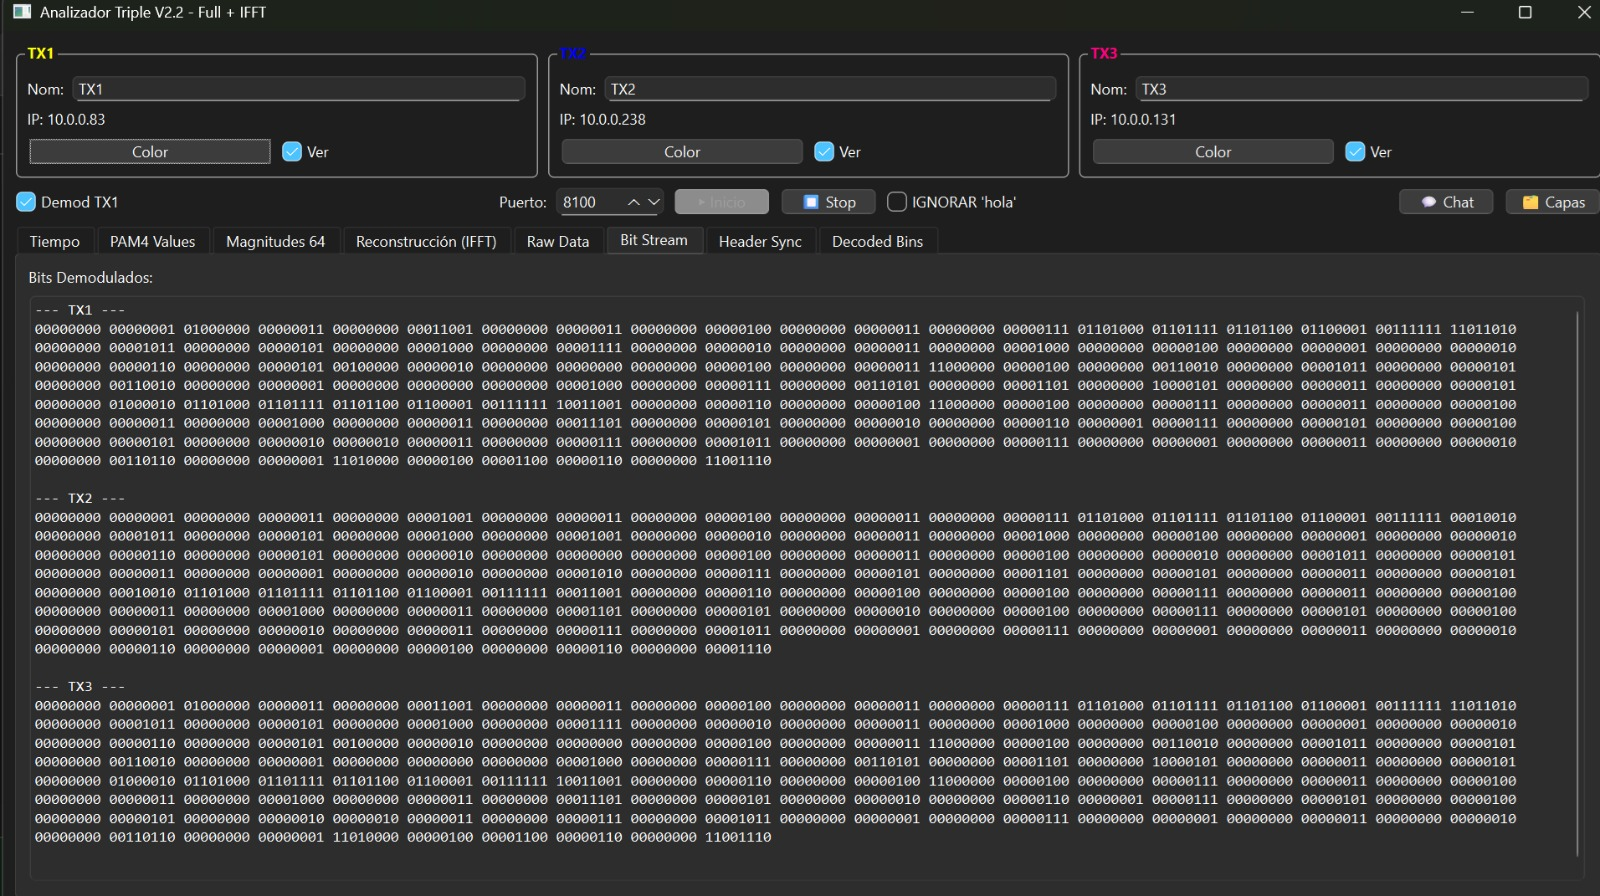

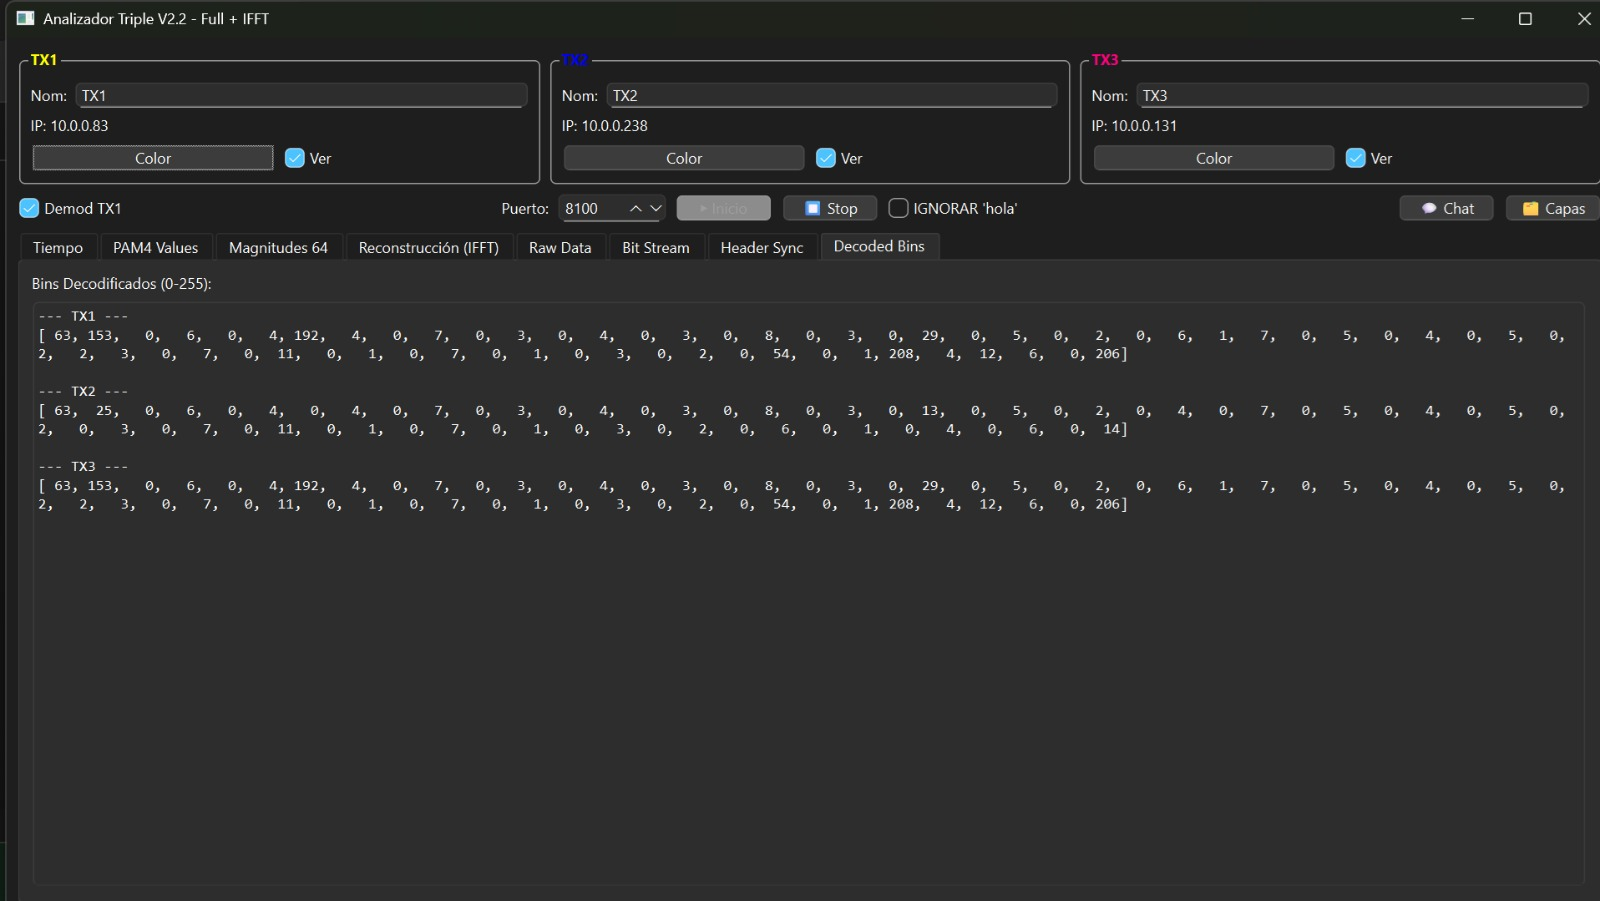

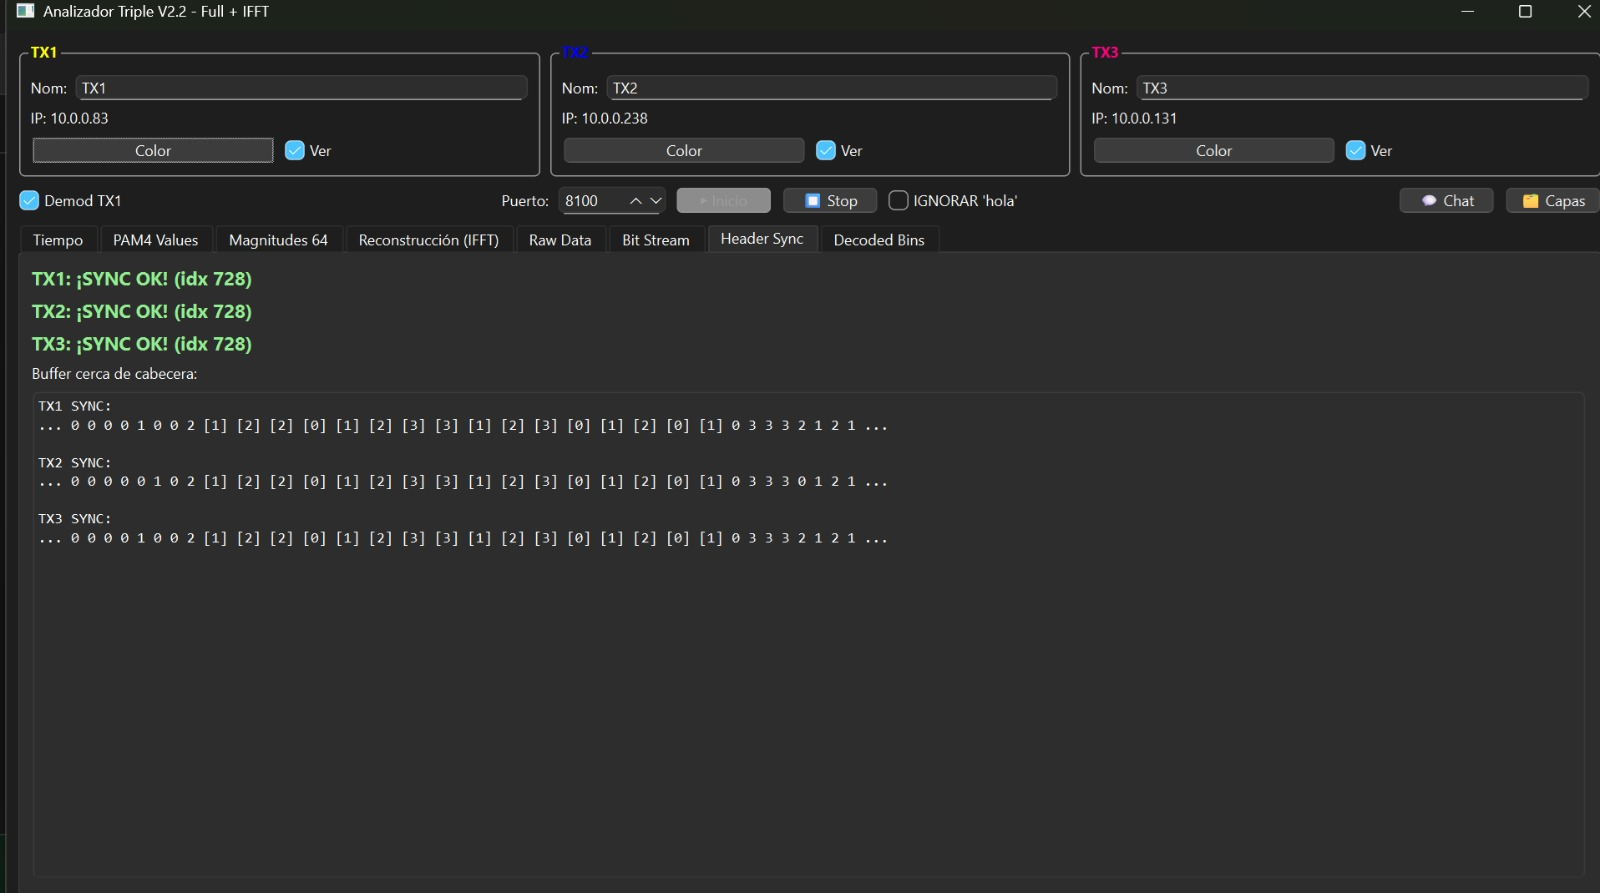

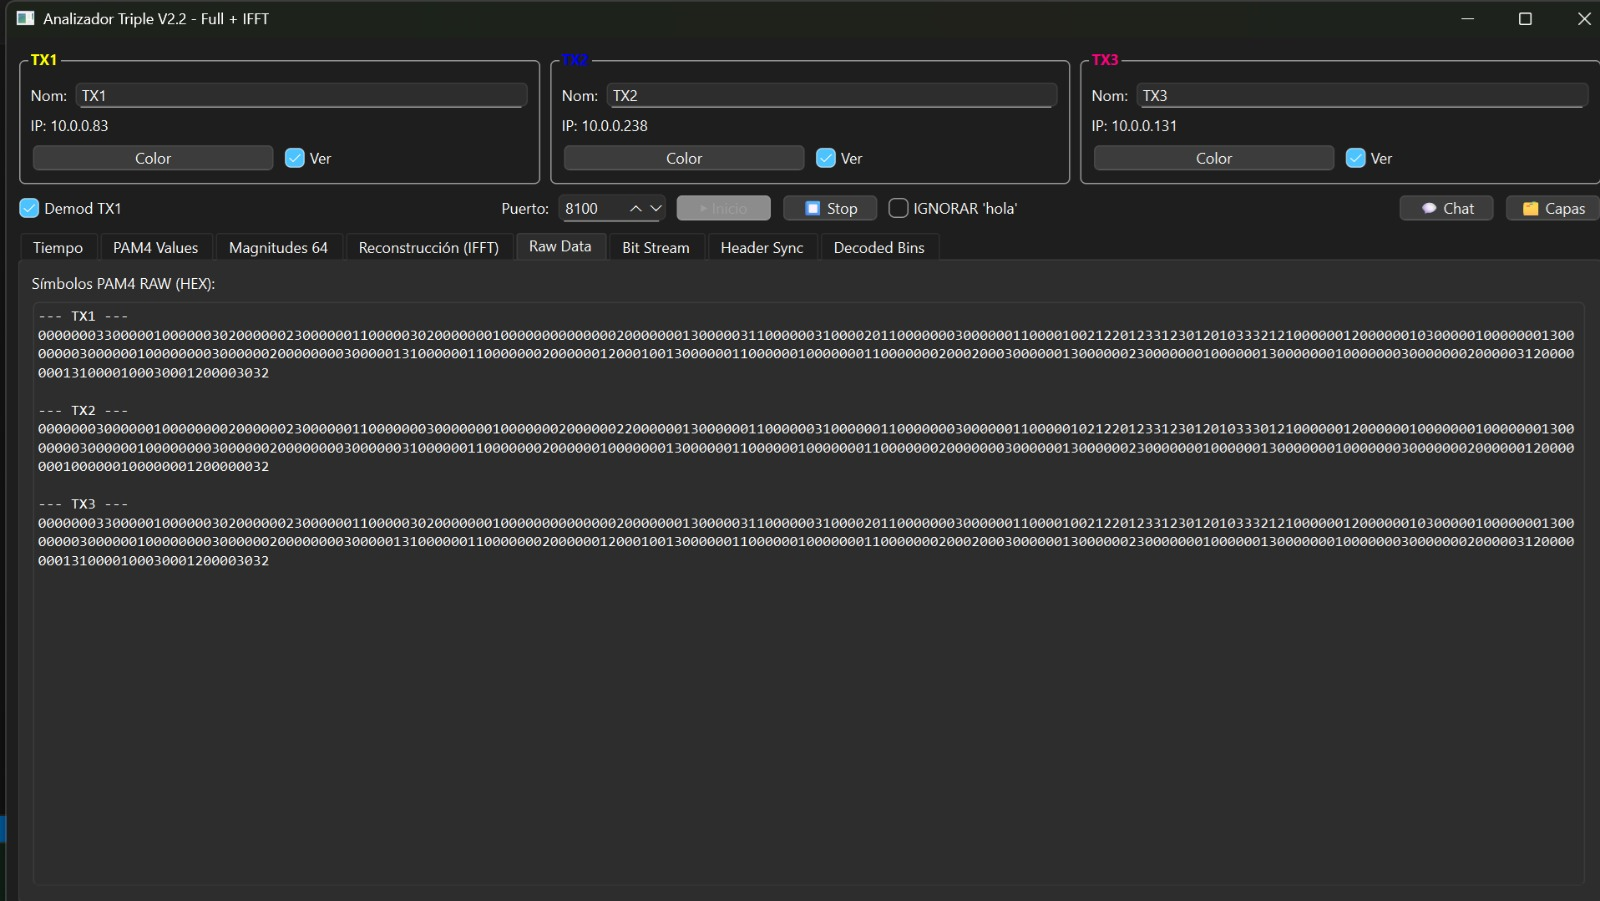

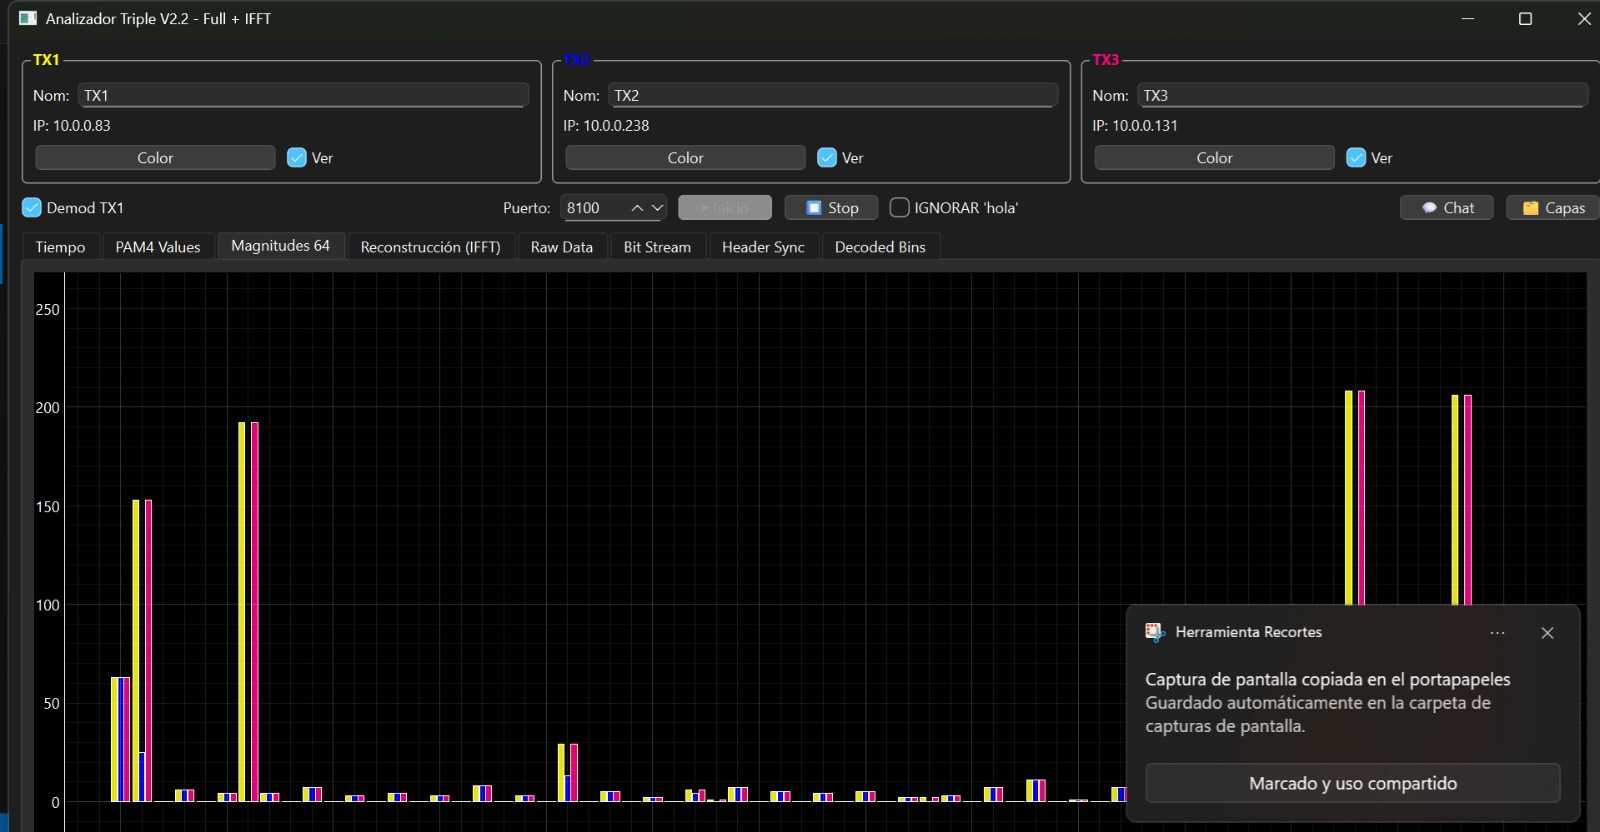